### PACKAGES

In [1]:
import pandas as pd
import math
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
import ast
import geopandas as gpd
import utm
from shapely.geometry import Point, MultiPolygon
import seaborn as sns
import json
#!pip install --upgrade numpy==1.21
from haversine import haversine, Unit
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
## Esta librería no te servirá en este análisis, pero
## es la librería básica para scrapear páginas más sencillas

from bs4 import BeautifulSoup as bs
import undetected_chromedriver as uc
import pandas as pd
import warnings
from sklearn.decomposition import PCA
# Turn off warning messages
warnings.filterwarnings('ignore')

from io import StringIO

### IMPORT DATA

In [2]:
url_idealista_collected_data_1 = "https://github.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/raw/fb65bda916b55a3f5199eba01688407dc47a1616/Data/Creation_Variables/Idealista_Collected_Data_1.csv"
url_idealista_collected_data_2 = "https://github.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/raw/fb65bda916b55a3f5199eba01688407dc47a1616/Data/Creation_Variables/Idealista_Collected_Data_2.csv"
response = requests.get(url_idealista_collected_data_1)
content = response.content.decode("utf-8")
df1 = pd.read_csv(StringIO(content))
response = requests.get(url_idealista_collected_data_2)
content = response.content.decode("utf-8")
df2 = pd.read_csv(StringIO(content))
data = pd.concat([df1,df2])


In [3]:
print(len(data))
data.drop_duplicates(['id'],inplace=True)
print(len(data))

16323
16301


In [4]:
data.set_index('id', inplace=True)

## COMMENT

**Files For The Distance To Public Services and Ammenities Were To Large To Share On Github. They Should Be Downloaded and Stored on the Computer Of The User. The Files Are Shared In A Google Drive: <br> https://drive.google.com/drive/folders/1yJTdjOwgUryLlGJVic1aZKiB05qPxtBn?usp=sharing**

In [5]:
#path were files are stored on PC user
distance_path = r"C:\Users\niels\python\UPF\Thesis\Distance\\"

## FUNCTIONS

In [6]:

df_setup_distance = pd.DataFrame(index=data.index)
def create_distance_var_df(main_data, features, dic_features, load_path):
    df_setup = pd.DataFrame(index=main_data.index)
    for feature in features:
        print(feature)
        with open(load_path+feature+'_distance.txt', 'r') as f:
            d = f.read()
        # returns JSON object as 
        # a dictionary
        js = json.loads(d)
        s = pd.Series(js)
        df = s.to_frame(name='distance_list')
        df.index = df.index.astype('int64')
        df['Distance to nearest '+feature] = df['distance_list'].apply(lambda x: min(x,  default=math.nan))
        if feature in dic_features:
            for ratio in dic_features[feature]:
                df['Number of '+feature+" within "+str(ratio)+' km'] = df['distance_list'].apply(lambda x: sum([1 for i in x if i < ratio]))
        try:
            with open(distance_path+feature+'_missing.txt','r') as f:
                d= [line.strip() for line in f.readlines()]
                for element in d:
                    df.loc[int(element),'Distance to nearest '+feature] = max(df['Distance to nearest '+feature])
                for element in d:
                    for ratio in dic_features[feature]:
                        df.loc[int(element),'Number of '+feature+" within "+str(ratio)+' km'] = 0               
        except:
            pass
        print(f'feature is {feature} and length df is: {len(df)}')
        df.drop('distance_list',axis=1,inplace=True)
        df_setup = df_setup.merge(df, left_index=True, right_index=True, how='left')
    return df_setup

In [7]:
def create_gpkg_level_var(main_data, features, gpkg_url_base):
    df_setup = main_data[['subdistrict', 'district']].copy(deep=True)#pd.DataFrame(index=main_data.index, col=data['subdistrict'])
    for feature in features:
        print(feature)
        #with open(load_path+feature+'_distance.txt', 'r') as f:
        #   d = f.read()
        # returns JSON object as 
        # a dictionary
        #js = json.loads(d)
        url = gpkg_url_base+ feature+'_distance.txt'
        print(url)
        response = requests.get(url)

        # Extract the text content
        content = response.text
        try:
            # Parse the content as a dictionary
            dictionary = ast.literal_eval(content)
        except:
            dictionary = json.loads(content)
        #s = pd.Series(js)
        s = pd.Series(dictionary)
        naam = feature+'_score'
        df = s.to_frame(name=naam)
        df.index = df.index.astype('int64')
        print(len(df_setup))
        df_setup = df_setup.merge(df, left_index=True, right_index=True, how='left')
        print(len(df_setup))
        #try:
        #    with open(load_path+feature+'_missing.txt','r') as f:
        #        d= [line.strip() for line in f.readlines()]
        #        for element in d:
        #            subdistrict = df_setup.loc[int(element)]['subdistrict']
        #            #print(subdistrict)
        #            median = df_setup[df_setup.subdistrict == subdistrict][naam].median()
        #            df_setup.loc[int(element),naam] = median
        #            print(f'subdistrict: {subdistrict} with median {median} and new value {df_setup.loc[int(element)][naam]}')
        #            if np.isnan(df_setup.loc[int(element),naam]):
        #                print('True')                 
        #except:
        #    pass
    return df_setup

In [8]:
def missing_values_median_subdistrict(dataset, variable):
    subdistricts = dataset.subdistrict.unique()
    median = {}
    avg = {}
    for sub in subdistricts:
        sub_df = dataset[dataset['subdistrict'] == sub]
        median[sub] = sub_df[variable].median()
        avg[sub] = sub_df[variable].mean()
    #median seems fine
    for index, row in dataset.iterrows():
        row = (dataset.loc[index])
        if np.isnan(row[variable]):
            key = row['subdistrict']
            med_val = median[key]
            #print(med_val)
            dataset.loc[index, variable] = median[key]
            #print(df_features.loc[index]['age'])
    return dataset

In [9]:
def pca_creation(df, input_variables, n_components, components_name, change_sign=False):
    variable_names = []
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[input_variables])
    desired_scale = 1
    for i in range(1,n_components+1):
        variable_names.append(components_name+' PCA Component ' +str(i))
    X = df[input_variables]
    pca = PCA(n_components=n_components)
    pca.fit(X)
    coefficients = pca.components_
    print(coefficients)
    if change_sign == False:    
        pca_variables = pca.fit_transform(X)
    if change_sign == True:
        pca_variables = pca.fit_transform(X) * -1
    rescale_factor = [0] * n_components
        
    #print(pca_variables)
    pca_df = pd.DataFrame(pca_variables,index=df.index, columns=variable_names)
    scaler = MinMaxScaler(feature_range=(0, desired_scale))
    # Scale the DataFrame
    scaled_df = pd.DataFrame(scaler.fit_transform(pca_df), columns=pca_df.columns,index=pca_df.index)
    scaling_factors = scaler.scale_
    print(scaling_factors)
    for i in range(n_components):
        #print(pca.explained_variance_ratio_)
        print(f'Explained Variance by Component {i} is {pca.explained_variance_ratio_[i]}%.')
        for x in range(len(input_variables)):
            if change_sign == False:
                print(f'Coefficient for {input_variables[x]} is {coefficients[i][x] * scaling_factors[i]}')
            if change_sign == True:
                print(f'Coefficient for {input_variables[x]} is {coefficients[i][x]*-1 * scaling_factors[i]}')
    return scaled_df

### SET-UP

In [10]:
"Can Be Adjusted To Export Files On Computer"
export_sustainable_variables = False
sustainable_path = r"C:\Users\niels\python\UPF\Thesis\sustainable_features\\"

## ECOLOGICAL

In [11]:
df_ecological = data[['subdistrict']].copy(deep=True)
df_ecological.head(3)
ecological_features_distance = ['bus', 'highway','metro','train']
ecological_features_gkpg = []
ecological_features_stats = []
ecological_ratio_within_dic = {}
ecological_ratio_within_dic['bus'] = [2.5,1, 0.5,0.25, 0.1]
ecological_ratio_within_dic['metro'] = [2.5,1, 0.5,0.25, 0.1]
ecological_ratio_within_dic['train'] = [5,2.5,1, 0.5,0.25]

**DISTANCE FEATURES**

In [12]:
ecological_features_distance_df = create_distance_var_df(data, ecological_features_distance,ecological_ratio_within_dic, distance_path)

bus
feature is bus and length df is: 16301
highway
feature is highway and length df is: 16301
metro
feature is metro and length df is: 16301
train
feature is train and length df is: 16301


In [13]:
ecological_features_distance_df['Nearest Highway or Train'] = ecological_features_distance_df[[ 'Distance to nearest highway', 'Distance to nearest train']].min(axis=1)

**GPKG FEATURES**

In [14]:
#nothing

**STATS FEATURES**

In [15]:
#nothing

**MERGING DATASETS**

In [16]:
#only ecological ratio dimension
ecological_features_df = df_ecological.merge(ecological_features_distance_df, left_index=True, right_index=True)

**TREATING MISSING VALUES**

In [17]:
"No Missing Values"
ecological_features_df.isnull().sum(axis = 0)

subdistrict                       0
Distance to nearest bus           0
Number of bus within 2.5 km       0
Number of bus within 1 km         0
Number of bus within 0.5 km       0
Number of bus within 0.25 km      0
Number of bus within 0.1 km       0
Distance to nearest highway       0
Distance to nearest metro         0
Number of metro within 2.5 km     0
Number of metro within 1 km       0
Number of metro within 0.5 km     0
Number of metro within 0.25 km    0
Number of metro within 0.1 km     0
Distance to nearest train         0
Number of train within 5 km       0
Number of train within 2.5 km     0
Number of train within 1 km       0
Number of train within 0.5 km     0
Number of train within 0.25 km    0
Nearest Highway or Train          0
dtype: int64

**HISTOGRAMS BEFORE TREATMENT AND SELECTION**

Histogram for: Distance to nearest bus


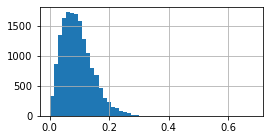



Histogram for: Number of bus within 2.5 km


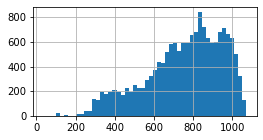



Histogram for: Number of bus within 1 km


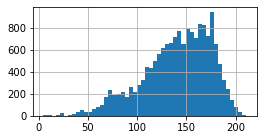



Histogram for: Number of bus within 0.5 km


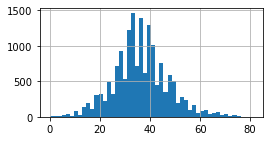



Histogram for: Number of bus within 0.25 km


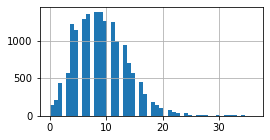



Histogram for: Number of bus within 0.1 km


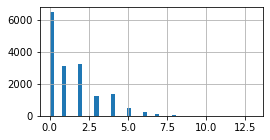



Histogram for: Distance to nearest highway


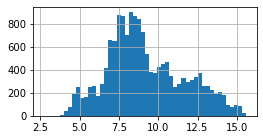



Histogram for: Distance to nearest metro


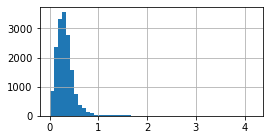



Histogram for: Number of metro within 2.5 km


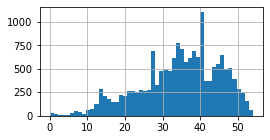



Histogram for: Number of metro within 1 km


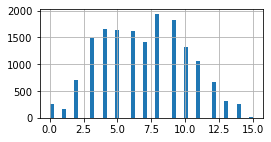



Histogram for: Number of metro within 0.5 km


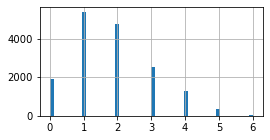



Histogram for: Number of metro within 0.25 km


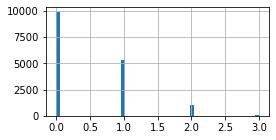



Histogram for: Number of metro within 0.1 km


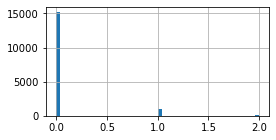



Histogram for: Distance to nearest train


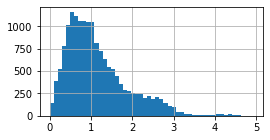



Histogram for: Number of train within 5 km


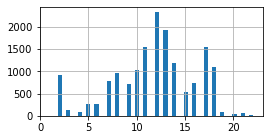



Histogram for: Number of train within 2.5 km


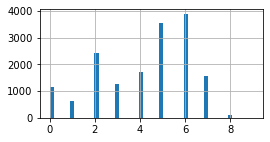



Histogram for: Number of train within 1 km


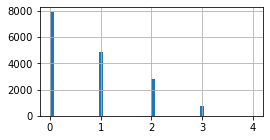



Histogram for: Number of train within 0.5 km


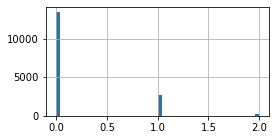



Histogram for: Number of train within 0.25 km


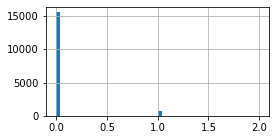



Histogram for: Nearest Highway or Train


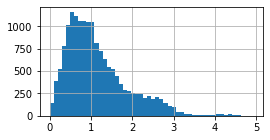

In [18]:
for col in ecological_features_df.iloc[:,1:].columns:
    print(f'Histogram for: {col}')
    ecological_features_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**SELECT FEATURES AND TRUNCUATION**

In [19]:
ecological_features_select = ['Distance to nearest bus','Number of bus within 0.25 km','Distance to nearest highway','Distance to nearest metro','Number of metro within 0.25 km','Distance to nearest train','Number of train within 0.5 km','Nearest Highway or Train']
ecological_features_select_df = ecological_features_df[ecological_features_select]

In [20]:
ecological_features_select_df.describe()

,Distance to nearest bus,Number of bus within 0.25 km,Distance to nearest highway,Distance to nearest metro,Number of metro within 0.25 km,Distance to nearest train,Number of train within 0.5 km,Nearest Highway or Train
count,16301.000000,16301.000000,16301.000000,16301.000000,16301.000000,16301.000000,16301.000000,16301.000000
mean,0.093242,9.210785,9.193232,0.326932,0.464511,1.149719,0.188332,1.149719
std,0.052761,4.673314,2.451920,0.250543,0.633750,0.744941,0.422222,0.744941
min,0.000856,0.000000,2.698749,0.003705,0.000000,0.007443,0.000000,0.007443
25%,0.054309,6.000000,7.497737,0.194212,0.000000,0.602310,0.000000,0.602310
50%,0.086209,9.000000,8.735633,0.289634,0.000000,0.976506,0.000000,0.976506
75%,0.123080,12.000000,10.817112,0.396281,1.000000,1.511838,0.000000,1.511838
max,0.681462,36.000000,15.609799,4.167137,3.000000,4.911729,2.000000,4.911729


Histogram for: Distance to nearest bus


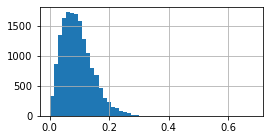



Histogram for: Number of bus within 0.25 km


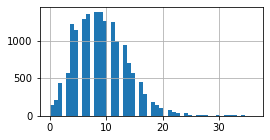



Histogram for: Distance to nearest highway


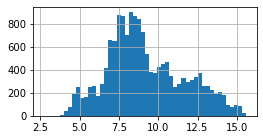



Histogram for: Distance to nearest metro


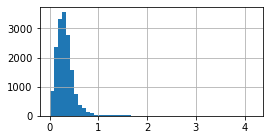



Histogram for: Number of metro within 0.25 km


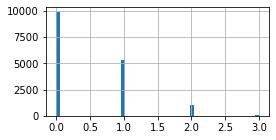



Histogram for: Distance to nearest train


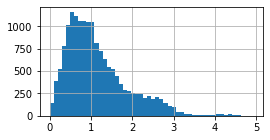



Histogram for: Number of train within 0.5 km


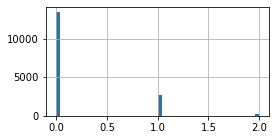



Histogram for: Nearest Highway or Train


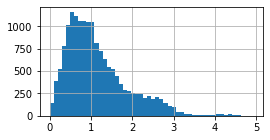

In [21]:
for col in ecological_features_select_df.columns:
    print(f'Histogram for: {col}')
    ecological_features_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

In [22]:
print(ecological_features_select)
ecological_features_select_df['Distance to nearest bus'] = ecological_features_select_df['Distance to nearest bus'].clip( 0, 0.4)
ecological_features_select_df['Number of bus within 0.25 km'] = ecological_features_select_df['Number of bus within 0.25 km'].clip(0, 25)
ecological_features_select_df['Distance to nearest highway'] = np.clip(ecological_features_select_df['Distance to nearest highway'], 0, 10)
ecological_features_select_df['Distance to nearest metro'] = np.clip(ecological_features_select_df['Distance to nearest metro'],0,1.25)
ecological_features_select_df['Number of metro within 0.25 km'] = np.clip(ecological_features_select_df['Number of metro within 0.25 km'],0,2)
ecological_features_select_df['Distance to nearest train'] = np.clip(ecological_features_select_df['Distance to nearest train'],0,3.5)
ecological_features_select_df['Number of train within 0.5 km'] = np.clip(ecological_features_select_df['Number of train within 0.5 km'],0,1)

['Distance to nearest bus', 'Number of bus within 0.25 km', 'Distance to nearest highway', 'Distance to nearest metro', 'Number of metro within 0.25 km', 'Distance to nearest train', 'Number of train within 0.5 km', 'Nearest Highway or Train']


Histogram for: Distance to nearest bus


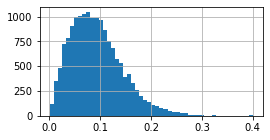



Histogram for: Number of bus within 0.25 km


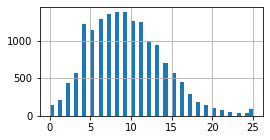



Histogram for: Distance to nearest highway


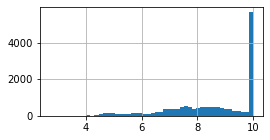



Histogram for: Distance to nearest metro


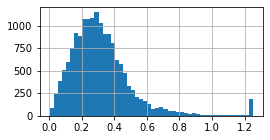



Histogram for: Number of metro within 0.25 km


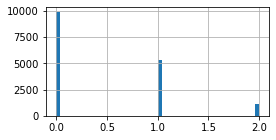



Histogram for: Distance to nearest train


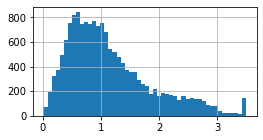



Histogram for: Number of train within 0.5 km


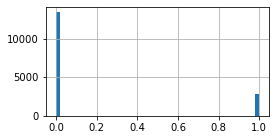



Histogram for: Nearest Highway or Train


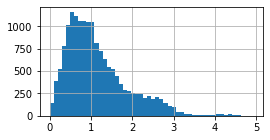

In [23]:
for col in ecological_features_select_df.columns:
    print(f'Histogram for: {col}')
    ecological_features_select_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**PCA VARIABLES**

In [24]:
ecological_features_select_df.columns

Index(['Distance to nearest bus', 'Number of bus within 0.25 km',
       'Distance to nearest highway', 'Distance to nearest metro',
       'Number of metro within 0.25 km', 'Distance to nearest train',
       'Number of train within 0.5 km', 'Nearest Highway or Train'],
      dtype='object')

*bus*

In [25]:
pca_bus_df = pca_creation(ecological_features_select_df, ['Distance to nearest bus', 'Number of bus within 0.25 km'], 1, 'Bus stations')

[[-0.00449078  0.99998992]]
[0.03999757]
Explained Variance by Component 0 is 0.9998913623295977%.
Coefficient for Distance to nearest bus is -0.00017962038923305377
Coefficient for Number of bus within 0.25 km is 0.03999716362842973


*metro*

In [26]:
pca_metro_df = pca_creation(ecological_features_select_df, ['Distance to nearest metro', 'Number of metro within 0.25 km'], 2, 'Metro stations')

[[-0.20071163  0.97965037]
 [ 0.97965037  0.20071163]]
[0.45267202 0.98017888]
Explained Variance by Component 0 is 0.9461054108414889%.
Coefficient for Distance to nearest metro is -0.0908565412457068
Coefficient for Number of metro within 0.25 km is 0.4434603103843382
Explained Variance by Component 1 is 0.05389458915851112%.
Coefficient for Distance to nearest metro is 0.9602326034014257
Coefficient for Number of metro within 0.25 km is 0.19673330643908565


*bus & metro*

In [27]:
pca_bus_metro_df = pca_creation(ecological_features_select_df, ['Distance to nearest bus', 'Number of bus within 0.25 km','Distance to nearest metro', 'Number of metro within 0.25 km'], 1, 'Bus & Metro stations')

[[-0.00448701  0.99953719 -0.00501795  0.0296665 ]]
[0.03991129]
Explained Variance by Component 0 is 0.981167458815382%.
Coefficient for Distance to nearest bus is -0.00017908241829521723
Coefficient for Number of bus within 0.25 km is 0.03989281564519907
Coefficient for Distance to nearest metro is -0.0002002728602387905
Coefficient for Number of metro within 0.25 km is 0.00118402821440324


*train & highway*

In [28]:
pca_highway_train_df = pca_creation(ecological_features_select_df, ['Distance to nearest highway', 'Distance to nearest train'], 1, 'Highway & Train stations')

[[-0.97410615 -0.22609115]]
[0.13376469]
Explained Variance by Component 0 is 0.8490273623433666%.
Coefficient for Distance to nearest highway is -0.13030100566407576
Coefficient for Distance to nearest train is -0.030243011721215112


*train*

In [29]:
pca_train_df = pca_creation(ecological_features_select_df, ['Distance to nearest train', 'Number of train within 0.5 km'], 1, 'Train stations', True)

[[ 0.94912269 -0.31490653]]
[0.27549945]
Explained Variance by Component 0 is 0.8554324109019495%.
Coefficient for Distance to nearest train is -0.26148277668217756
Coefficient for Number of train within 0.5 km is 0.08675657527085959


*pca_merge*

In [30]:
ecological_features_select_df = ecological_features_select_df.merge(pca_bus_df, left_index=True, right_index=True)
ecological_features_select_df = ecological_features_select_df.merge(pca_train_df, left_index=True, right_index=True)
ecological_features_select_df = ecological_features_select_df.merge(pca_metro_df, left_index=True, right_index=True)
ecological_features_select_df = ecological_features_select_df.merge(pca_bus_metro_df, left_index=True, right_index=True)
ecological_features_select_df = ecological_features_select_df.merge(pca_highway_train_df, left_index=True, right_index=True)
ecological_features_select_df.head(2)

,Distance to nearest bus,Number of bus within 0.25 km,Distance to nearest highway,Distance to nearest metro,Number of metro within 0.25 km,Distance to nearest train,Number of train within 0.5 km,Nearest Highway or Train,Bus stations PCA Component 1,Train stations PCA Component 1,Metro stations PCA Component 1,Metro stations PCA Component 2,Bus & Metro stations PCA Component 1,Highway & Train stations PCA Component 1
id,,,,,,,,,,,,,,
31702050,0.108865,16,8.585996,0.206594,1,0.247580,1,0.247580,0.640007,0.937208,0.538261,0.194821,0.639730,0.282609
33148486,0.097694,10,8.340155,0.275196,0,0.279798,1,0.279798,0.400026,0.928784,0.088567,0.063961,0.399178,0.313668


**EXPORT ECOLOGICAL FEATURES**

In [31]:
#ecological_features_select_df
if export_sustainable_variables: 

    ecological_features_select_df.to_excel(sustainable_path+'ecological_dimension.xlsx')
ecological_features_select_df.head(2)

,Distance to nearest bus,Number of bus within 0.25 km,Distance to nearest highway,Distance to nearest metro,Number of metro within 0.25 km,Distance to nearest train,Number of train within 0.5 km,Nearest Highway or Train,Bus stations PCA Component 1,Train stations PCA Component 1,Metro stations PCA Component 1,Metro stations PCA Component 2,Bus & Metro stations PCA Component 1,Highway & Train stations PCA Component 1
id,,,,,,,,,,,,,,
31702050,0.108865,16,8.585996,0.206594,1,0.247580,1,0.247580,0.640007,0.937208,0.538261,0.194821,0.639730,0.282609
33148486,0.097694,10,8.340155,0.275196,0,0.279798,1,0.279798,0.400026,0.928784,0.088567,0.063961,0.399178,0.313668


 ## ENVIRONMENTAL

**definitions**

In [32]:
environmental_df = data[['subdistrict']].copy(deep=True)
environmental_df.head(3)
environmental_features_distance = ['park_and_garden','viewpoints','beach']
environmental_features_gpkg = ['noise_pollution','level_of_heat_comfort']
environmental_features_gpkg = ['level_of_heat_comfort','vulnerable_factor_heatimpact']
environmental_features_stats = ['neighboorhood_size']
environmental_ratio_within_dic = {}
environmental_ratio_within_dic['park_and_garden'] = [2.5,1,0.5, 0.25]
environmental_ratio_within_dic['viewpoints'] = [2.5,1,0.5, 0.25]


**distance features**

In [33]:
environmental_features_distance_df = create_distance_var_df(data, environmental_features_distance,environmental_ratio_within_dic, distance_path)
environmental_features_distance_df.head(2)

park_and_garden
feature is park_and_garden and length df is: 16301
viewpoints
feature is viewpoints and length df is: 16301
beach
feature is beach and length df is: 16301


,Distance to nearest park_and_garden,Number of park_and_garden within 2.5 km,Number of park_and_garden within 1 km,Number of park_and_garden within 0.5 km,Number of park_and_garden within 0.25 km,Distance to nearest viewpoints,Number of viewpoints within 2.5 km,Number of viewpoints within 1 km,Number of viewpoints within 0.5 km,Number of viewpoints within 0.25 km,Distance to nearest beach
id,,,,,,,,,,,
31702050,0.240334,110,19,5,1,0.81787,2,1,0,0,2.448314
33148486,0.374747,114,18,4,0,1.11723,2,0,0,0,3.042559


**gkpg features**

In [34]:
gpkg_url_base = 'https://raw.githubusercontent.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/2ed24da4f5630d8226ac4f33ab133f149878ab76/Data/Sus_Var_Creation/housing_area_stats_gpkg//'
environmental_features_gpkg_df = create_gpkg_level_var(data, environmental_features_gpkg,gpkg_url_base)
environmental_features_gpkg_df.head(10)


level_of_heat_comfort
https://raw.githubusercontent.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/2ed24da4f5630d8226ac4f33ab133f149878ab76/Data/Sus_Var_Creation/housing_area_stats_gpkg//level_of_heat_comfort_distance.txt
16301
16301
vulnerable_factor_heatimpact
https://raw.githubusercontent.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/2ed24da4f5630d8226ac4f33ab133f149878ab76/Data/Sus_Var_Creation/housing_area_stats_gpkg//vulnerable_factor_heatimpact_distance.txt
16301
16301


,subdistrict,district,level_of_heat_comfort_score,vulnerable_factor_heatimpact_score
id,,,,
31702050,Subdistrict La Dreta de l'Eixample,District Eixample,3.0,2.0
33148486,Subdistrict La Dreta de l'Eixample,District Eixample,4.0,2.0
39158016,Subdistrict La Dreta de l'Eixample,District Eixample,4.0,2.0
40351755,Subdistrict La Dreta de l'Eixample,District Eixample,3.0,3.0
93970881,Subdistrict La Dreta de l'Eixample,District Eixample,4.0,2.0
84114683,Subdistrict La Dreta de l'Eixample,District Eixample,4.0,2.0
84144318,Subdistrict La Dreta de l'Eixample,District Eixample,4.0,3.0
84809865,Subdistrict La Dreta de l'Eixample,District Eixample,4.0,2.0
85156127,Subdistrict La Dreta de l'Eixample,District Eixample,4.0,2.0


**stats features**

In [35]:
print(environmental_features_stats)
url_base = 'https://github.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/blob/ec0b4379cb1cc274d71210aef7209d27750de492/Data/Sus_Var_Creation/subdistrict_stats/'


url_neighboorhood_size = url_base + "neighborhood_area_size.xlsx?raw=true"
response = requests.get(url_neighboorhood_size)
file_content = response.content
neighborhood_size_df= pd.read_excel(file_content)
neighbordhood_size_df = neighborhood_size_df.rename(columns={ 'Superfície (ha)': 'Neighboorhood size (ha)'}, inplace=True)
environmental_stats_features_df = neighborhood_size_df[['subdistrict','Neighboorhood size (ha)']]
environmental_stats_features_df.head(2)

['neighboorhood_size']


,subdistrict,Neighboorhood size (ha)
0,Subdistrict Baró de Viver,23.0
1,Subdistrict Can Baró,38.4


**MERGE ENVIRONMENTAL FEATURES**

In [36]:
environmental_features_df = environmental_df.merge(environmental_features_distance_df, left_index=True, right_index=True)
environmental_features_df = environmental_features_df.merge(environmental_features_gpkg_df[['level_of_heat_comfort_score','vulnerable_factor_heatimpact_score']], left_index=True, right_index=True)
environmental_features_df = environmental_features_df.reset_index('id')
environmental_features_df = environmental_features_df.merge(environmental_stats_features_df, left_on='subdistrict', right_on='subdistrict')
environmental_features_df.set_index('id', inplace=True)
print(len(environmental_features_df))
environmental_features_df.head(2)

16297


,subdistrict,Distance to nearest park_and_garden,Number of park_and_garden within 2.5 km,Number of park_and_garden within 1 km,Number of park_and_garden within 0.5 km,Number of park_and_garden within 0.25 km,Distance to nearest viewpoints,Number of viewpoints within 2.5 km,Number of viewpoints within 1 km,Number of viewpoints within 0.5 km,Number of viewpoints within 0.25 km,Distance to nearest beach,level_of_heat_comfort_score,vulnerable_factor_heatimpact_score,Neighboorhood size (ha)
id,,,,,,,,,,,,,,,
31702050,Subdistrict La Dreta de l'Eixample,0.240334,110,19,5,1,0.81787,2,1,0,0,2.448314,3.0,2.0,212.0
33148486,Subdistrict La Dreta de l'Eixample,0.374747,114,18,4,0,1.11723,2,0,0,0,3.042559,4.0,2.0,212.0


**MISSING VALUES ENVIRONMENTAL FEATURES**

In [37]:
"Missing Values For Level Of Heat Comfort Score"
print(environmental_features_df.isnull().sum(axis = 0))
environmental_features_df = missing_values_median_subdistrict(environmental_features_df, 'level_of_heat_comfort_score')
environmental_features_df = missing_values_median_subdistrict(environmental_features_df, 'vulnerable_factor_heatimpact_score')

subdistrict                                   0
Distance to nearest park_and_garden           0
Number of park_and_garden within 2.5 km       0
Number of park_and_garden within 1 km         0
Number of park_and_garden within 0.5 km       0
Number of park_and_garden within 0.25 km      0
Distance to nearest viewpoints                0
Number of viewpoints within 2.5 km            0
Number of viewpoints within 1 km              0
Number of viewpoints within 0.5 km            0
Number of viewpoints within 0.25 km           0
Distance to nearest beach                     0
level_of_heat_comfort_score                 111
vulnerable_factor_heatimpact_score          110
Neighboorhood size (ha)                       0
dtype: int64


In [38]:
'Problem Solved'
print(environmental_features_df.isnull().sum(axis = 0))

subdistrict                                 0
Distance to nearest park_and_garden         0
Number of park_and_garden within 2.5 km     0
Number of park_and_garden within 1 km       0
Number of park_and_garden within 0.5 km     0
Number of park_and_garden within 0.25 km    0
Distance to nearest viewpoints              0
Number of viewpoints within 2.5 km          0
Number of viewpoints within 1 km            0
Number of viewpoints within 0.5 km          0
Number of viewpoints within 0.25 km         0
Distance to nearest beach                   0
level_of_heat_comfort_score                 0
vulnerable_factor_heatimpact_score          0
Neighboorhood size (ha)                     0
dtype: int64


**HISTOGRAMS BEFORE TREATMENT AND SELECTION**

Histogram for: Distance to nearest park_and_garden


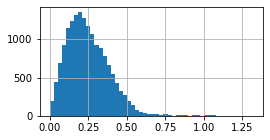



Histogram for: Number of park_and_garden within 2.5 km


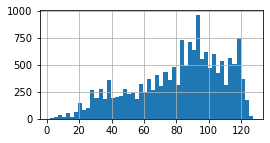



Histogram for: Number of park_and_garden within 1 km


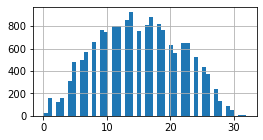



Histogram for: Number of park_and_garden within 0.5 km


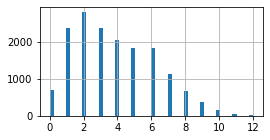



Histogram for: Number of park_and_garden within 0.25 km


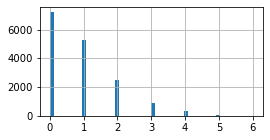



Histogram for: Distance to nearest viewpoints


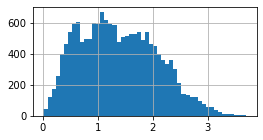



Histogram for: Number of viewpoints within 2.5 km


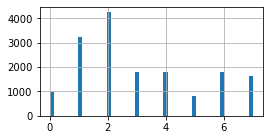



Histogram for: Number of viewpoints within 1 km


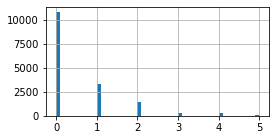



Histogram for: Number of viewpoints within 0.5 km


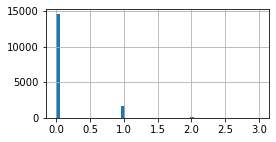



Histogram for: Number of viewpoints within 0.25 km


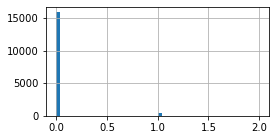



Histogram for: Distance to nearest beach


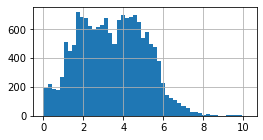



Histogram for: level_of_heat_comfort_score


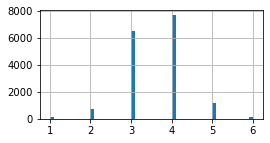



Histogram for: vulnerable_factor_heatimpact_score


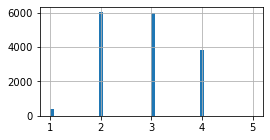



Histogram for: Neighboorhood size (ha)


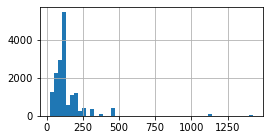

In [39]:
for col in environmental_features_df.iloc[:,1:].columns:
    print(f'Histogram for: {col}')
    environmental_features_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**SELECT FEATURES AND TRUNCUATION OF DISTANCE VARIABLES**

In [40]:
environmental_features_select = ['Distance to nearest park_and_garden','Number of park_and_garden within 0.25 km','Distance to nearest viewpoints','Number of viewpoints within 1 km','Distance to nearest beach','level_of_heat_comfort_score','vulnerable_factor_heatimpact_score','Neighboorhood size (ha)']
environmental_features_select_df = environmental_features_df[environmental_features_select]

In [41]:
environmental_features_select_df['Distance to nearest park_and_garden'] = environmental_features_select_df['Distance to nearest park_and_garden'].clip(0,0.5)
environmental_features_select_df['Number of park_and_garden within 0.25 km'] = environmental_features_select_df['Number of park_and_garden within 0.25 km'].clip(0,2)
environmental_features_select_df['Distance to nearest viewpoints'] = environmental_features_select_df['Distance to nearest viewpoints'].clip(0,3)
environmental_features_select_df['Number of viewpoints within 1 km'] = environmental_features_select_df['Number of viewpoints within 1 km'].clip(0,2)
environmental_features_select_df['Distance to nearest beach'] = environmental_features_select_df['Distance to nearest beach'].clip(0,5)


Histogram for: Distance to nearest park_and_garden


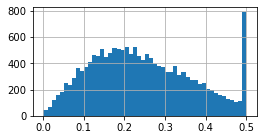



Histogram for: Number of park_and_garden within 0.25 km


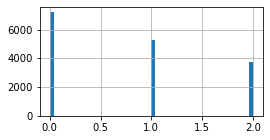



Histogram for: Distance to nearest viewpoints


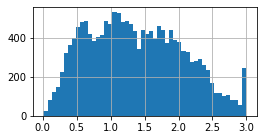



Histogram for: Number of viewpoints within 1 km


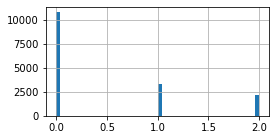



Histogram for: Distance to nearest beach


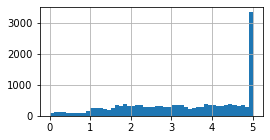



Histogram for: level_of_heat_comfort_score


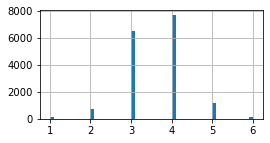



Histogram for: vulnerable_factor_heatimpact_score


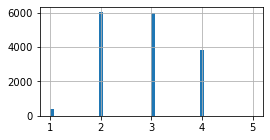



Histogram for: Neighboorhood size (ha)


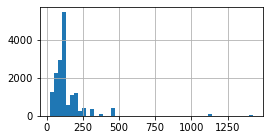

In [42]:
for col in environmental_features_select_df.columns:
    print(f'Histogram for: {col}')
    environmental_features_select_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**PCA**

*park and gardens*

In [43]:
pca_park_and_gardens_df = pca_creation(environmental_features_select_df, ['Distance to nearest park_and_garden', 'Number of park_and_garden within 0.25 km'], 1, 'Parks and Gardens')

[[-0.125063   0.9921488]]
[0.48859708]
Explained Variance by Component 0 is 0.9915461124417111%.
Coefficient for Distance to nearest park_and_garden is -0.06110541864941434
Coefficient for Number of park_and_garden within 0.25 km is 0.4847610052132385


*viewpoints*

In [44]:
pca_viewpoints_df = pca_creation(environmental_features_select_df, ['Distance to nearest viewpoints', 'Number of viewpoints within 1 km'], 1, 'Viewpoints', False)

[[-0.69175567  0.72213163]]
[0.28468223]
Explained Variance by Component 0 is 0.8706637774058693%.
Coefficient for Distance to nearest viewpoints is -0.1969305460380578
Coefficient for Number of viewpoints within 1 km is 0.20557804282187134


array([[<AxesSubplot:title={'center':'Viewpoints PCA Component 1'}>]],
      dtype=object)

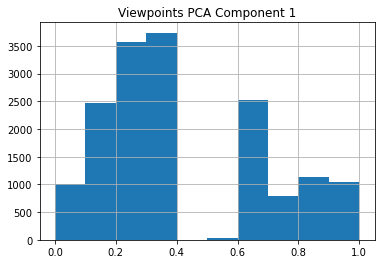

In [45]:
pca_viewpoints_df.hist()

*pca merge*

In [46]:
environmental_features_select_df = environmental_features_select_df.merge(pca_park_and_gardens_df, left_index=True, right_index=True)
environmental_features_select_df = environmental_features_select_df.merge(pca_viewpoints_df, left_index=True, right_index=True)

In [47]:
environmental_features_select_df.corr()

,Distance to nearest park_and_garden,Number of park_and_garden within 0.25 km,Distance to nearest viewpoints,Number of viewpoints within 1 km,Distance to nearest beach,level_of_heat_comfort_score,vulnerable_factor_heatimpact_score,Neighboorhood size (ha),Parks and Gardens PCA Component 1,Viewpoints PCA Component 1
Distance to nearest park_and_garden,1.000000,-0.799785,0.022938,-0.011472,-0.025868,0.005209,0.145455,0.044112,-0.806718,-0.018209
Number of park_and_garden within 0.25 km,-0.799785,1.000000,0.008998,-0.010540,0.005198,-0.034115,-0.160272,0.010029,0.999932,-0.010500
Distance to nearest viewpoints,0.022938,0.008998,1.000000,-0.741019,0.358057,0.018023,-0.172165,-0.005092,0.008413,-0.927725
Number of viewpoints within 1 km,-0.011472,-0.010540,-0.741019,1.000000,-0.278815,-0.072120,0.198924,0.037629,-0.010153,0.938103
Distance to nearest beach,-0.025868,0.005198,0.358057,-0.278815,1.000000,-0.079924,0.026213,0.070443,0.005619,-0.339676
level_of_heat_comfort_score,0.005209,-0.034115,0.018023,-0.072120,-0.079924,1.000000,0.011365,-0.053852,-0.033685,-0.049386
vulnerable_factor_heatimpact_score,0.145455,-0.160272,-0.172165,0.198924,0.026213,0.011365,1.000000,-0.129631,-0.160596,0.199382
Neighboorhood size (ha),0.044112,0.010029,-0.005092,0.037629,0.070443,-0.053852,-0.129631,1.000000,0.009017,0.023544
Parks and Gardens PCA Component 1,-0.806718,0.999932,0.008413,-0.010153,0.005619,-0.033685,-0.160596,0.009017,1.000000,-0.009984
Viewpoints PCA Component 1,-0.018209,-0.010500,-0.927725,0.938103,-0.339676,-0.049386,0.199382,0.023544,-0.009984,1.000000


**EXPORT ENVIRONMENTAL FEATURES**

In [48]:
#ecological_features_select_df
if export_sustainable_variables: 
    environmental_features_select_df.to_excel(sustainable_path+'environmental_dimension.xlsx')
    environmental_features_select_df.head(2)

## SOCIAL

**SET-UP**

In [49]:
social_df = data[['subdistrict']].copy(deep=True)
social_df.head(3)
social_features_distance = ['police_stations','cinema','theatre','concert','bar','restaurant']
social_features_distance += ['under_three_education','three_to_six_education','primary_school','secundary_school','university']
social_features_distance += ['pharmacy', 'hospital_and_cliniques','shopping_gallery','shopping_centre','large_establishment','market']
social_features_gpkg = ['social_cohesion']
social_features_stats = ['immigration_rate','emigration_rate','life_expactancy','mortality_rate']
social_features_stats +=  ['birth_rate','population_density','demographics_age']
social_ratio_within_dic = {}
social_ratio_within_dic['police_stations'] = [5,2.5,1]
social_ratio_within_dic['cinema'] = [5,2.5,1,0.5]
social_ratio_within_dic['theatre'] = [5,2.5,1,0.5]
social_ratio_within_dic['concert'] =[5,2.5,1,0.5]
social_ratio_within_dic['bar'] = [5,2.5,1,0.5, 0.25]
social_ratio_within_dic['restaurant'] = [5,2.5,1,0.5,0.25]
social_ratio_within_dic['under_three_education'] = [5,2.5,1,0.5]
social_ratio_within_dic['three_to_six_education'] = [5,2.5,1,0.5]
social_ratio_within_dic['primary_school'] = [5,2.5,1,0.5]
social_ratio_within_dic['secundary_school'] = [5,2.5,1,0.5]
social_ratio_within_dic['university'] = [5,2.5,1,0.5]
social_ratio_within_dic['pharmacy'] = [2.5,1,0.5,0.25]
social_ratio_within_dic['hospital_and_cliniques'] = [5,2.5,1,0.5]
social_ratio_within_dic['shopping_gallery'] = [2.5,1,0.5]
social_ratio_within_dic['shopping_centre'] = [2.5,1,0.5]
social_ratio_within_dic['large_establishment'] = [2.5,1,0.5]
social_ratio_within_dic['market'] = [2.5,1,0.5]

**FEATURES DISTANCE**

In [50]:
social_feature_distance_df = create_distance_var_df(data, social_features_distance,social_ratio_within_dic, distance_path)
social_feature_distance_df.head(2)

police_stations
feature is police_stations and length df is: 16301
cinema
feature is cinema and length df is: 16301
theatre
feature is theatre and length df is: 16301
concert
feature is concert and length df is: 16301
bar
feature is bar and length df is: 16301
restaurant
feature is restaurant and length df is: 16301
under_three_education
feature is under_three_education and length df is: 16301
three_to_six_education
feature is three_to_six_education and length df is: 16301
primary_school
feature is primary_school and length df is: 16301
secundary_school
feature is secundary_school and length df is: 16301
university
feature is university and length df is: 16301
pharmacy
feature is pharmacy and length df is: 16301
hospital_and_cliniques
feature is hospital_and_cliniques and length df is: 16301
shopping_gallery
feature is shopping_gallery and length df is: 16301
shopping_centre
feature is shopping_centre and length df is: 16301
large_establishment
feature is large_establishment and length

,Distance to nearest police_stations,Number of police_stations within 5 km,Number of police_stations within 2.5 km,Number of police_stations within 1 km,Distance to nearest cinema,Number of cinema within 5 km,Number of cinema within 2.5 km,Number of cinema within 1 km,Number of cinema within 0.5 km,Distance to nearest theatre,...,Number of shopping_centre within 1 km,Number of shopping_centre within 0.5 km,Distance to nearest large_establishment,Number of large_establishment within 2.5 km,Number of large_establishment within 1 km,Number of large_establishment within 0.5 km,Distance to nearest market,Number of market within 2.5 km,Number of market within 1 km,Number of market within 0.5 km
id,,,,,,,,,,,,,,,,,,,,,
31702050,0.507050,25,13,2,0.187379,24,16,5,2,0.194059,...,6,2,0.127685,28,10,5,0.495230,35,3,1
33148486,0.792018,26,12,2,0.556233,25,19,6,0,0.459548,...,1,1,0.111814,28,14,4,0.748613,38,3,0


**FEATURES GKPG**

In [51]:
gpkg_url_base = 'https://raw.githubusercontent.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/ec0b4379cb1cc274d71210aef7209d27750de492/Data/Sus_Var_Creation/housing_area_stats_gpkg/'
social_features_gpkg_df = create_gpkg_level_var(data,social_features_gpkg,gpkg_url_base)

social_features_gpkg_df.head(2)
social_features_gpkg_df.isnull().sum(axis = 0)
social_features_gpkg_df['social_cohesion_score'] = social_features_gpkg_df['social_cohesion_score'] / 100

social_cohesion
https://raw.githubusercontent.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/ec0b4379cb1cc274d71210aef7209d27750de492/Data/Sus_Var_Creation/housing_area_stats_gpkg/social_cohesion_distance.txt
16301
16301


**FEATURES STATS**

In [52]:
print(social_features_stats)
stats_path = r'C:\Users\niels\python\UPF\Thesis\Area_stats\\'
url_base = 'https://github.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/blob/ec0b4379cb1cc274d71210aef7209d27750de492/Data/Sus_Var_Creation/subdistrict_stats/'

url_immigration = url_base + "immigration.xlsx?raw=true"
response = requests.get(url_immigration)
file_content = response.content
immigration_df = pd.read_excel(file_content)
immigration_df.rename(columns={'Perc':'Immigration rate %'},inplace=True)
immigration_df = immigration_df[['Immigration rate %', 'subdistrict']]

url_emigration = url_base + "emigration.xlsx?raw=true"
response = requests.get(url_immigration)
file_content = response.content
emigration_df = pd.read_excel(file_content)
emigration_df.rename(columns={'Perc':'Emigration rate %'},inplace=True)
emigration_df = emigration_df[['Emigration rate %', 'subdistrict']]



url_life_expactancy = url_base + "life_expectancy.xlsx?raw=true"
response = requests.get(url_life_expactancy)
file_content = response.content
life_expectancy_df = pd.read_excel(file_content)
life_expectancy_df.rename(columns={'Nombre':'Life expectancy'},inplace=True)
life_expectancy_df = life_expectancy_df[['Life expectancy','subdistrict']]

url_birth_rate = url_base + "birth_rate.xlsx?raw=true"
response = requests.get(url_birth_rate)
file_content = response.content
birth_rate_df = pd.read_excel(file_content)
birth_rate_df.rename(columns={'Perc':'Birth rate %'}, inplace=True)
birth_rate_df= birth_rate_df[['Birth rate %', 'subdistrict']]


url_mortality_rate = url_base + "mortality_rate.xlsx?raw=true"
response = requests.get(url_mortality_rate)
file_content = response.content
mortality_rate_df = pd.read_excel(file_content)
mortality_rate_df.rename(columns={'Perc':'Mortality rate %'}, inplace=True)
mortality_rate_df = mortality_rate_df[['Mortality rate %', 'subdistrict']]


url_population_density = url_base + "population_density.xlsx?raw=true"
response = requests.get(url_population_density)
file_content = response.content
population_density_df = pd.read_excel(file_content)
population_density_df.rename(columns={'Densitat neta (hab/ha)':'Density net (hab/ha)'},inplace=True)
population_density_df.rename(columns={'Densitat (hab/ha)':'Density (hab/ha)'},inplace=True)
population_density_df = population_density_df[['Density (hab/ha)','Density net (hab/ha)','subdistrict']]

url_demographics_age = url_base + "demographics_age.xlsx?raw=true"
response = requests.get(url_demographics_age)
file_content = response.content
demographics_age_df  = pd.read_excel(file_content)

demographics_age_under_18_df = demographics_age_df[demographics_age_df.Group=='under_18'].copy(deep=True)
demographics_age_under_18_df.rename(columns={'perc':'under 18 %'},inplace=True)
demographics_age_under_18_df = demographics_age_under_18_df[['under 18 %', 'subdistrict']]

demographics_age_64_plus_df = demographics_age_df[demographics_age_df.Group=='64_plus'].copy(deep=True)
demographics_age_64_plus_df.rename(columns={'perc':'64 plus %'},inplace=True)
demographics_age_64_plus_df = demographics_age_64_plus_df[['64 plus %', 'subdistrict']]

social_stats_features_df = immigration_df.merge(emigration_df, left_on='subdistrict', right_on='subdistrict')
social_stats_features_df = social_stats_features_df.merge(life_expectancy_df, left_on='subdistrict', right_on='subdistrict')
social_stats_features_df = social_stats_features_df.merge(birth_rate_df, left_on='subdistrict', right_on='subdistrict')
social_stats_features_df = social_stats_features_df.merge(mortality_rate_df, left_on='subdistrict', right_on='subdistrict')
social_stats_features_df = social_stats_features_df.merge(population_density_df, left_on='subdistrict', right_on='subdistrict')
social_stats_features_df = social_stats_features_df.merge(demographics_age_under_18_df, left_on='subdistrict', right_on='subdistrict')
social_stats_features_df = social_stats_features_df.merge(demographics_age_64_plus_df, left_on='subdistrict', right_on='subdistrict')

social_stats_features_df['Natural population growth %'] = social_stats_features_df['Birth rate %'] - social_stats_features_df['Mortality rate %']
social_stats_features_df['Net immigration rate %'] = social_stats_features_df['Immigration rate %'] - social_stats_features_df['Emigration rate %']
social_stats_features_df["Natural population growth ‰"]  = social_stats_features_df['Natural population growth %']/100
social_stats_features_df['Net immigration rate ‰']  = social_stats_features_df['Net immigration rate %']  / 100
pca_social_stats_features_df = pca_creation(social_stats_features_df,["Natural population growth ‰",
      'Net immigration rate ‰'], 1, "Population Growth", False)

social_stats_features_df = social_stats_features_df.drop(['Birth rate %', 'Mortality rate %','Immigration rate %','Emigration rate %'], axis=1)
social_stats_features_df.head(2)

['immigration_rate', 'emigration_rate', 'life_expactancy', 'mortality_rate', 'birth_rate', 'population_density', 'demographics_age']
[[-1. -0.]]
[7986.5719416]
Explained Variance by Component 0 is 1.0%.
Coefficient for Natural population growth ‰ is -7986.571941603562
Coefficient for Net immigration rate ‰ is -0.0


,subdistrict,Life expectancy,Density (hab/ha),Density net (hab/ha),under 18 %,64 plus %,Natural population growth %,Net immigration rate %,Natural population growth ‰,Net immigration rate ‰
0,Subdistrict Baró de Viver,79.142857,115,673.0,0.337772,0.179397,-0.0027,0.0,-0.000027,0.0
1,Subdistrict Can Baró,83.840000,240,645.0,0.302195,0.212366,-0.0005,0.0,-0.000005,0.0


In [53]:
population_density_df

,Density (hab/ha),Density net (hab/ha),subdistrict
0,115,673.000000,Subdistrict Baró de Viver
1,240,645.000000,Subdistrict Can Baró
2,319,781.500000,Subdistrict Can Peguera - El Turó de la Peira
3,86,620.000000,Subdistrict Canyelles
4,111,356.333333,Subdistrict Ciutat Meridiana - Torre Baró - Va...
...,...,...,...
63,129,335.000000,Subdistrict Vallcarca i els Penitents
64,4,19.000000,Subdistrict Vallvidrera - El Tibidabo i les Pl...
65,537,894.000000,Subdistrict Verdun
66,375,589.000000,Subdistrict Vila de Gràcia


**MERGE**

In [54]:
social_features_df = social_df.merge(social_feature_distance_df, left_index=True, right_index=True)
social_features_df = social_features_df.drop(['subdistrict'], axis=1)
social_features_df = social_features_df.merge(social_features_gpkg_df, left_index=True, right_index=True)
social_features_df = social_features_df.reset_index('id')
social_features_df = social_features_df.merge(social_stats_features_df, left_on='subdistrict', right_on='subdistrict')
social_features_df.set_index('id', inplace=True)
social_features_df.head(2)

,Distance to nearest police_stations,Number of police_stations within 5 km,Number of police_stations within 2.5 km,Number of police_stations within 1 km,Distance to nearest cinema,Number of cinema within 5 km,Number of cinema within 2.5 km,Number of cinema within 1 km,Number of cinema within 0.5 km,Distance to nearest theatre,...,social_cohesion_score,Life expectancy,Density (hab/ha),Density net (hab/ha),under 18 %,64 plus %,Natural population growth %,Net immigration rate %,Natural population growth ‰,Net immigration rate ‰
id,,,,,,,,,,,,,,,,,,,,,
31702050,0.507050,25,13,2,0.187379,24,16,5,2,0.194059,...,NaN,83.35,211,392.0,0.256247,0.210564,-0.0032,0.0,-0.000032,0.0
33148486,0.792018,26,12,2,0.556233,25,19,6,0,0.459548,...,0.22,83.35,211,392.0,0.256247,0.210564,-0.0032,0.0,-0.000032,0.0


**MISSING VALUES SOCIAL FEATURES**

In [55]:
"Missing values social cohesion"
old = 0
for i in range(0,100,10):
    print(social_features_df.iloc[:,old:i].isnull().sum(axis=0))
    old = i
social_features_df = missing_values_median_subdistrict(social_features_df, 'social_cohesion_score')
social_features_df['Distance to nearest bar'] = social_features_df['Distance to nearest bar'].fillna(social_features_df['Distance to nearest bar'].max())
#environmental_features_df = missing_values_median_subdistrict(environmental_features_df, 'level_of_heat_comfort_score')

Series([], dtype: float64)
Distance to nearest police_stations        0
Number of police_stations within 5 km      0
Number of police_stations within 2.5 km    0
Number of police_stations within 1 km      0
Distance to nearest cinema                 0
Number of cinema within 5 km               0
Number of cinema within 2.5 km             0
Number of cinema within 1 km               0
Number of cinema within 0.5 km             0
Distance to nearest theatre                0
dtype: int64
Number of theatre within 5 km       0
Number of theatre within 2.5 km     0
Number of theatre within 1 km       0
Number of theatre within 0.5 km     0
Distance to nearest concert         0
Number of concert within 5 km       0
Number of concert within 2.5 km     0
Number of concert within 1 km       0
Number of concert within 0.5 km     0
Distance to nearest bar            50
dtype: int64
Number of bar within 5 km             0
Number of bar within 2.5 km           0
Number of bar within 1 km            

In [56]:
"problem solved"

print(social_features_df[['social_cohesion_score', 'Distance to nearest bar']].isnull().sum(axis=0))

social_cohesion_score      0
Distance to nearest bar    0
dtype: int64


**HISTOGRAMS BEFORE TREATMENT AND SELECTION**

Histogram for: Distance to nearest police_stations


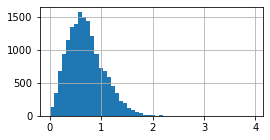



Histogram for: Number of police_stations within 5 km


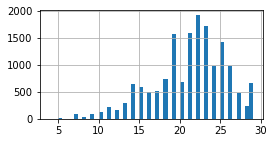



Histogram for: Number of police_stations within 2.5 km


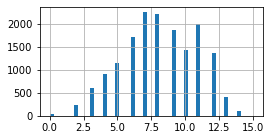



Histogram for: Number of police_stations within 1 km


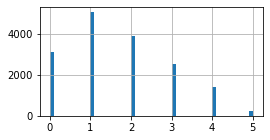



Histogram for: Distance to nearest cinema


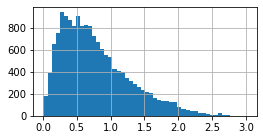



Histogram for: Number of cinema within 5 km


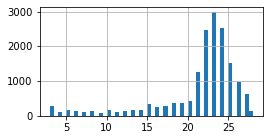



Histogram for: Number of cinema within 2.5 km


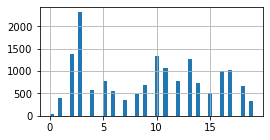



Histogram for: Number of cinema within 1 km


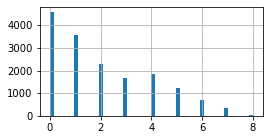



Histogram for: Number of cinema within 0.5 km


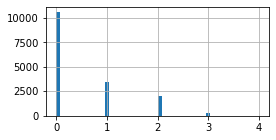



Histogram for: Distance to nearest theatre


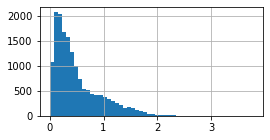



Histogram for: Number of theatre within 5 km


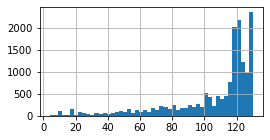



Histogram for: Number of theatre within 2.5 km


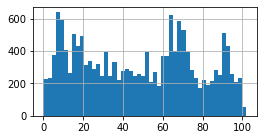



Histogram for: Number of theatre within 1 km


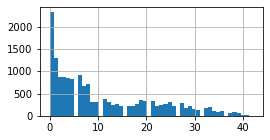



Histogram for: Number of theatre within 0.5 km


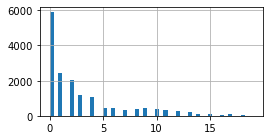



Histogram for: Distance to nearest concert


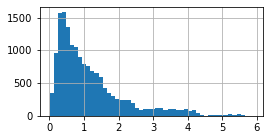



Histogram for: Number of concert within 5 km


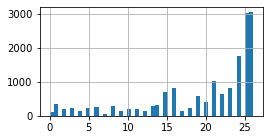



Histogram for: Number of concert within 2.5 km


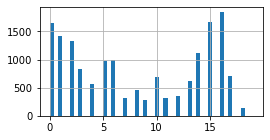



Histogram for: Number of concert within 1 km


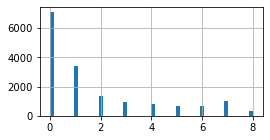



Histogram for: Number of concert within 0.5 km


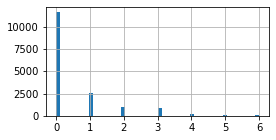



Histogram for: Distance to nearest bar


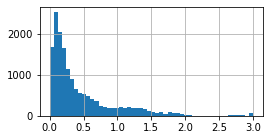



Histogram for: Number of bar within 5 km


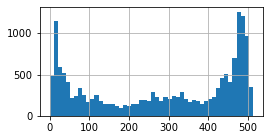



Histogram for: Number of bar within 2.5 km


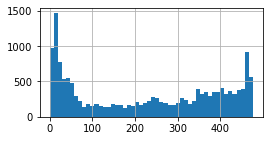



Histogram for: Number of bar within 1 km


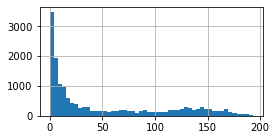



Histogram for: Number of bar within 0.5 km


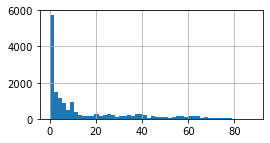



Histogram for: Number of bar within 0.25 km


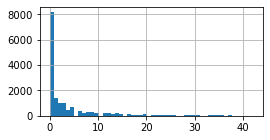



Histogram for: Distance to nearest restaurant


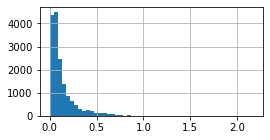



Histogram for: Number of restaurant within 5 km


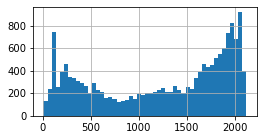



Histogram for: Number of restaurant within 2.5 km


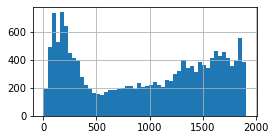



Histogram for: Number of restaurant within 1 km


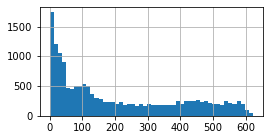



Histogram for: Number of restaurant within 0.5 km


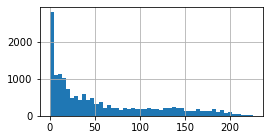



Histogram for: Number of restaurant within 0.25 km


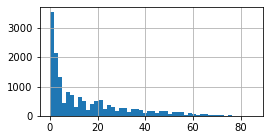



Histogram for: Distance to nearest under_three_education


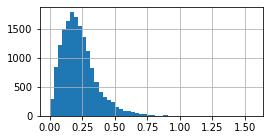



Histogram for: Number of under_three_education within 5 km


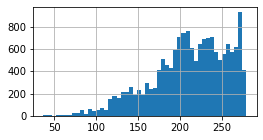



Histogram for: Number of under_three_education within 2.5 km


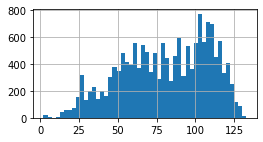



Histogram for: Number of under_three_education within 1 km


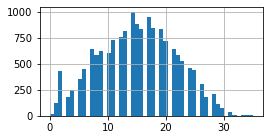



Histogram for: Number of under_three_education within 0.5 km


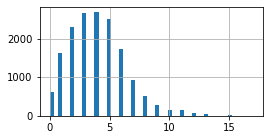



Histogram for: Distance to nearest three_to_six_education


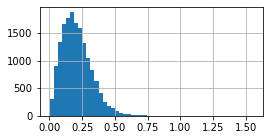



Histogram for: Number of three_to_six_education within 5 km


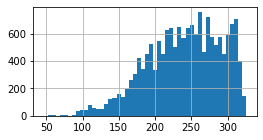



Histogram for: Number of three_to_six_education within 2.5 km


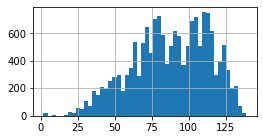



Histogram for: Number of three_to_six_education within 1 km


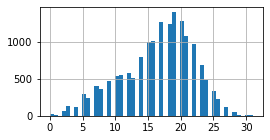



Histogram for: Number of three_to_six_education within 0.5 km


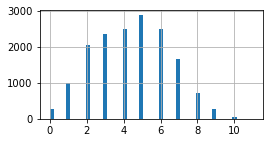



Histogram for: Distance to nearest primary_school


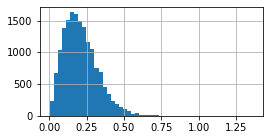



Histogram for: Number of primary_school within 5 km


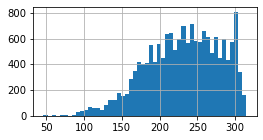



Histogram for: Number of primary_school within 2.5 km


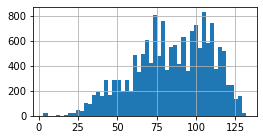



Histogram for: Number of primary_school within 1 km


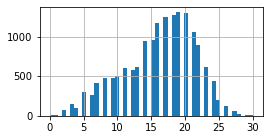



Histogram for: Number of primary_school within 0.5 km


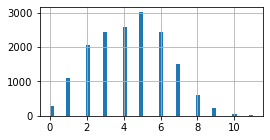



Histogram for: Distance to nearest secundary_school


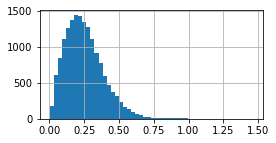



Histogram for: Number of secundary_school within 5 km


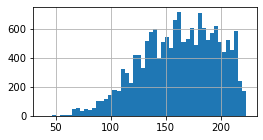



Histogram for: Number of secundary_school within 2.5 km


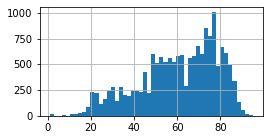



Histogram for: Number of secundary_school within 1 km


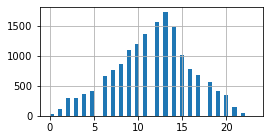



Histogram for: Number of secundary_school within 0.5 km


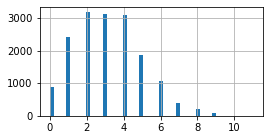



Histogram for: Distance to nearest university


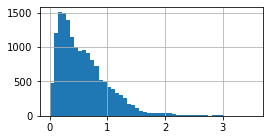



Histogram for: Number of university within 5 km


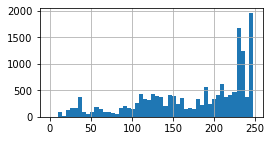



Histogram for: Number of university within 2.5 km


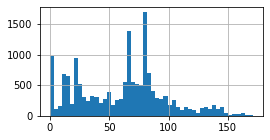



Histogram for: Number of university within 1 km


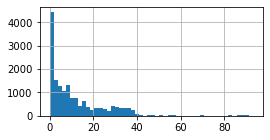



Histogram for: Number of university within 0.5 km


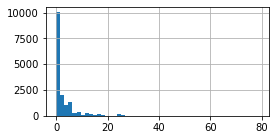



Histogram for: Distance to nearest pharmacy


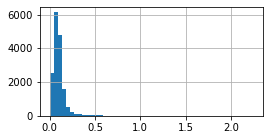



Histogram for: Number of pharmacy within 2.5 km


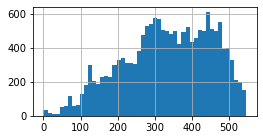



Histogram for: Number of pharmacy within 1 km


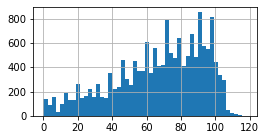



Histogram for: Number of pharmacy within 0.5 km


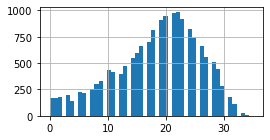



Histogram for: Number of pharmacy within 0.25 km


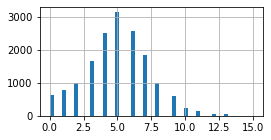



Histogram for: Distance to nearest hospital_and_cliniques


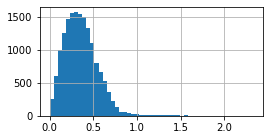



Histogram for: Number of hospital_and_cliniques within 5 km


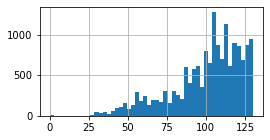



Histogram for: Number of hospital_and_cliniques within 2.5 km


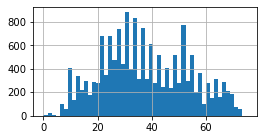



Histogram for: Number of hospital_and_cliniques within 1 km


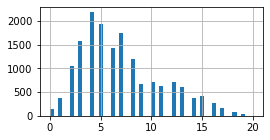



Histogram for: Number of hospital_and_cliniques within 0.5 km


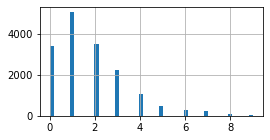



Histogram for: Distance to nearest shopping_gallery


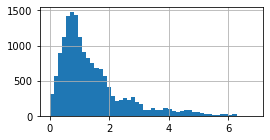



Histogram for: Number of shopping_gallery within 2.5 km


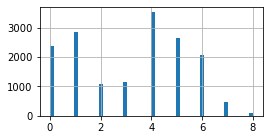



Histogram for: Number of shopping_gallery within 1 km


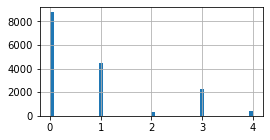



Histogram for: Number of shopping_gallery within 0.5 km


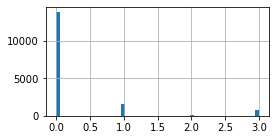



Histogram for: Distance to nearest shopping_centre


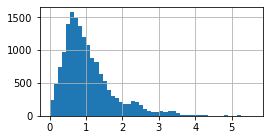



Histogram for: Number of shopping_centre within 2.5 km


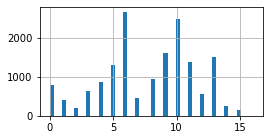



Histogram for: Number of shopping_centre within 1 km


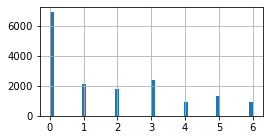



Histogram for: Number of shopping_centre within 0.5 km


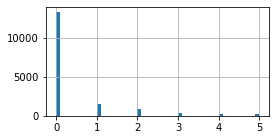



Histogram for: Distance to nearest large_establishment


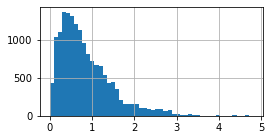



Histogram for: Number of large_establishment within 2.5 km


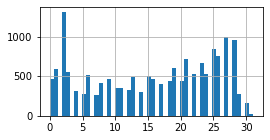



Histogram for: Number of large_establishment within 1 km


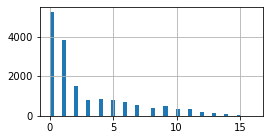



Histogram for: Number of large_establishment within 0.5 km


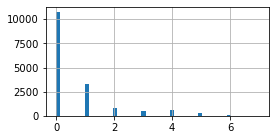



Histogram for: Distance to nearest market


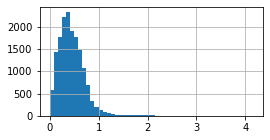



Histogram for: Number of market within 2.5 km


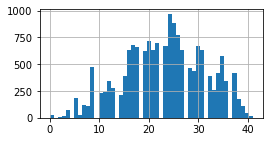



Histogram for: Number of market within 1 km


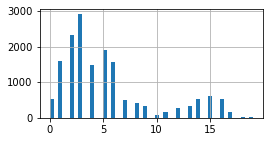



Histogram for: Number of market within 0.5 km


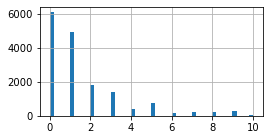



Histogram for: subdistrict


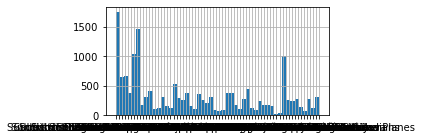



Histogram for: district


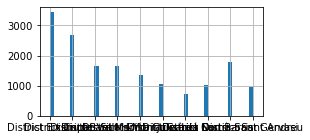



Histogram for: social_cohesion_score


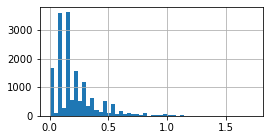



Histogram for: Life expectancy


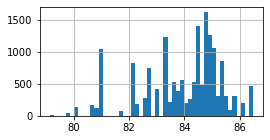



Histogram for: Density (hab/ha)


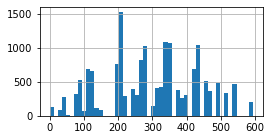



Histogram for: Density net (hab/ha)


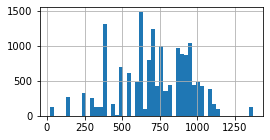



Histogram for: under 18 %


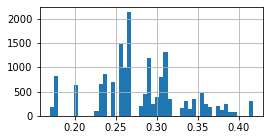



Histogram for: 64 plus %


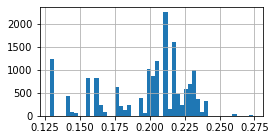



Histogram for: Natural population growth %


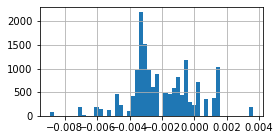



Histogram for: Net immigration rate %


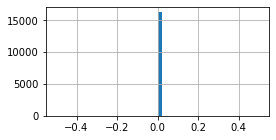



Histogram for: Natural population growth ‰


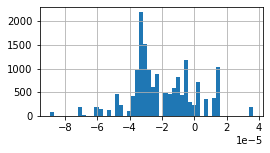



Histogram for: Net immigration rate ‰


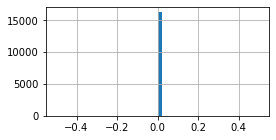

In [57]:
for col in social_features_df.columns:
    print(f'Histogram for: {col}')
    social_features_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**SELECT FEATURES AND TRUNCUATION OF DISTANCE VARIABLES**

In [58]:
social_features_select = ['Distance to nearest police_stations','Number of police_stations within 1 km','Distance to nearest cinema']
social_features_select += ['Number of cinema within 0.5 km','Distance to nearest theatre','Number of theatre within 0.5 km','Distance to nearest concert','Number of concert within 0.5 km']
social_features_select += ['Distance to nearest bar','Number of bar within 0.25 km','Distance to nearest restaurant', 'Number of restaurant within 0.25 km']
social_features_select += ['Distance to nearest under_three_education', 'Number of under_three_education within 0.5 km', 'Distance to nearest three_to_six_education','Number of three_to_six_education within 0.5 km']
social_features_select += ['Distance to nearest primary_school', 'Number of primary_school within 0.5 km', 'Distance to nearest secundary_school', 'Number of secundary_school within 0.5 km']
social_features_select += ['Distance to nearest university', 'Number of university within 0.5 km']
social_features_select += ['Distance to nearest pharmacy', 'Number of pharmacy within 0.25 km', 'Distance to nearest hospital_and_cliniques','Number of hospital_and_cliniques within 0.5 km']
social_features_select += ['Distance to nearest shopping_gallery','Number of shopping_gallery within 1 km', 'Distance to nearest shopping_centre','Number of shopping_centre within 1 km']
social_features_select += ["Distance to nearest large_establishment",'Number of large_establishment within 1 km','Distance to nearest market','Number of market within 1 km']
social_features_select += ['social_cohesion_score','Life expectancy','Density (hab/ha)','Density net (hab/ha)','under 18 %','64 plus %', 'Natural population growth %', 'Net immigration rate %']
social_features_select_df = social_features_df[social_features_select]

In [59]:
social_features_select_df['Distance to nearest police_stations'] = social_features_select_df['Distance to nearest police_stations'].clip(0, 2.5)
social_features_select_df['Number of police_stations within 1 km'] = social_features_select_df['Number of police_stations within 1 km'].clip(0, 4)
social_features_select_df['Distance to nearest cinema'] = social_features_select_df['Distance to nearest cinema'].clip(0, 2.5)
social_features_select_df['Number of cinema within 0.5 km'] = social_features_select_df['Number of cinema within 0.5 km'].clip(0, 2)
social_features_select_df[' Distance to nearest theatre'] = social_features_select_df['Distance to nearest theatre'].clip(0, 2.5)
social_features_select_df['Number of theatre within 0.5 km'] = social_features_select_df['Number of theatre within 0.5 km'].clip(0, 10)
social_features_select_df['Distance to nearest concert'] = social_features_select_df['Distance to nearest concert'].clip(0, 3)
social_features_select_df['Number of concert within 0.5 km'] = social_features_select_df['Number of concert within 0.5 km'].clip(0, 2)
social_features_select_df['Distance to nearest bar'] = social_features_select_df['Distance to nearest bar'].clip(0, 2)
social_features_select_df['Number of bar within 0.25 km'] = social_features_select_df['Number of bar within 0.25 km'].clip(0, 5)
social_features_select_df['Distance to nearest restaurant'] = social_features_select_df['Distance to nearest restaurant'].clip(0, 2.5)
social_features_select_df['Number of restaurant within 0.25 km'] = social_features_select_df['Number of restaurant within 0.25 km'].clip(0, 4)
social_features_select_df['Distance to nearest under_three_education'] = social_features_select_df['Distance to nearest under_three_education'].clip(0, 1)
social_features_select_df['Number of under_three_education within 0.5 km'] = social_features_select_df['Number of under_three_education within 0.5 km'].clip(0, 10)
social_features_select_df['Distance to nearest three_to_six_education'] = social_features_select_df['Distance to nearest three_to_six_education'].clip(0, 1)
social_features_select_df['Number of three_to_six_education within 0.5 km'] = social_features_select_df['Number of three_to_six_education within 0.5 km'].clip(0, 10)
social_features_select_df['Distance to nearest primary_school'] = social_features_select_df['Distance to nearest primary_school'].clip(0, 1)
social_features_select_df['Number of primary_school within 0.5 km'] = social_features_select_df['Number of primary_school within 0.5 km'].clip(0, 10)
social_features_select_df['Distance to nearest secundary_school'] = social_features_select_df['Distance to nearest secundary_school'].clip(0, 1)
social_features_select_df['Number of secundary_school within 0.5 km'] = social_features_select_df['Number of secundary_school within 0.5 km'].clip(0, 10)
social_features_select_df['Distance to nearest university'] = social_features_select_df['Distance to nearest university'].clip(0, 2.5)
social_features_select_df['Number of university within 0.5 km'] = social_features_select_df['Number of university within 0.5 km'].clip(0, 5)
social_features_select_df['Distance to nearest pharmacy'] = social_features_select_df['Distance to nearest pharmacy'].clip(0, 1)
social_features_select_df['Number of pharmacy within 0.25 km'] = social_features_select_df['Number of pharmacy within 0.25 km'].clip(0, 10)
social_features_select_df['Distance to nearest hospital_and_cliniques'] = social_features_select_df['Distance to nearest hospital_and_cliniques'].clip(0, 1.5)
social_features_select_df['Number of hospital_and_cliniques within 0.5 km'] = social_features_select_df['Number of hospital_and_cliniques within 0.5 km'].clip(0, 5)
social_features_select_df['Distance to nearest shopping_gallery'] = social_features_select_df['Distance to nearest shopping_gallery'].clip(0, 3)
social_features_select_df['Number of shopping_gallery within 1 km'] = social_features_select_df['Number of shopping_gallery within 1 km'].clip(0,3)
social_features_select_df['Distance to nearest shopping_centre'] = social_features_select_df['Distance to nearest shopping_centre'].clip(0, 3)
social_features_select_df['Number of shopping_centre within 1 km'] = social_features_select_df['Number of shopping_centre within 1 km'].clip(0, 3)
social_features_select_df['Distance to nearest large_establishment'] = social_features_select_df['Distance to nearest large_establishment'].clip(0, 3)
social_features_select_df['Number of large_establishment within 1 km'] = social_features_select_df['Number of large_establishment within 1 km'].clip(0, 9)
social_features_select_df['Distance to nearest market'] = social_features_select_df['Distance to nearest market'].clip(0, 3)
social_features_select_df['Number of market within 1 km'] = social_features_select_df['Number of market within 1 km'].clip(0, 10)

Histogram for: Distance to nearest police_stations


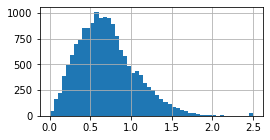



Histogram for: Number of police_stations within 1 km


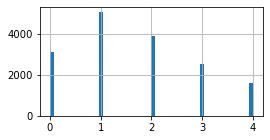



Histogram for: Distance to nearest cinema


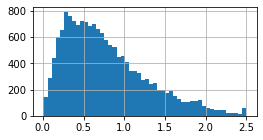



Histogram for: Number of cinema within 0.5 km


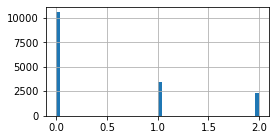



Histogram for: Distance to nearest theatre


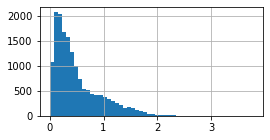



Histogram for: Number of theatre within 0.5 km


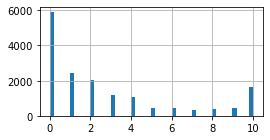



Histogram for: Distance to nearest concert


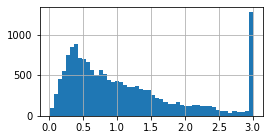



Histogram for: Number of concert within 0.5 km


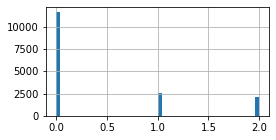



Histogram for: Distance to nearest bar


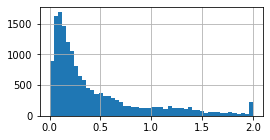



Histogram for: Number of bar within 0.25 km


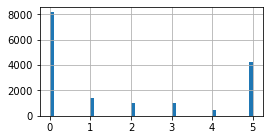



Histogram for: Distance to nearest restaurant


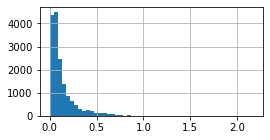



Histogram for: Number of restaurant within 0.25 km


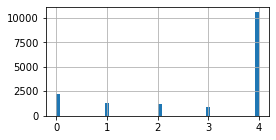



Histogram for: Distance to nearest under_three_education


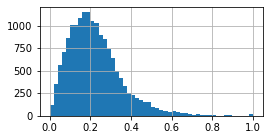



Histogram for: Number of under_three_education within 0.5 km


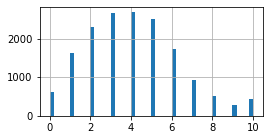



Histogram for: Distance to nearest three_to_six_education


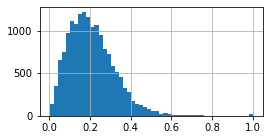



Histogram for: Number of three_to_six_education within 0.5 km


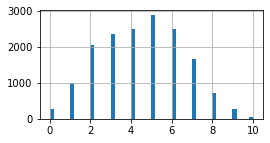



Histogram for: Distance to nearest primary_school


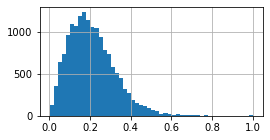



Histogram for: Number of primary_school within 0.5 km


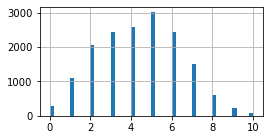



Histogram for: Distance to nearest secundary_school


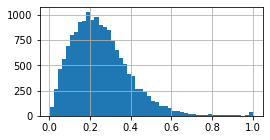



Histogram for: Number of secundary_school within 0.5 km


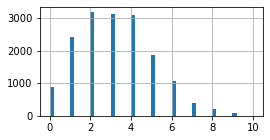



Histogram for: Distance to nearest university


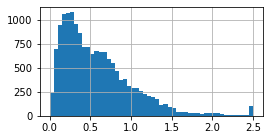



Histogram for: Number of university within 0.5 km


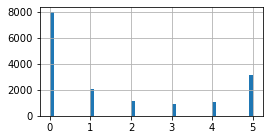



Histogram for: Distance to nearest pharmacy


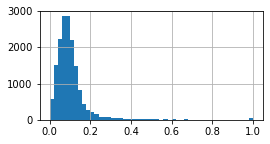



Histogram for: Number of pharmacy within 0.25 km


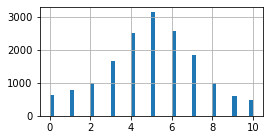



Histogram for: Distance to nearest hospital_and_cliniques


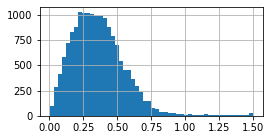



Histogram for: Number of hospital_and_cliniques within 0.5 km


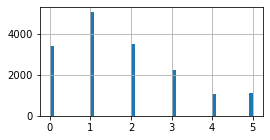



Histogram for: Distance to nearest shopping_gallery


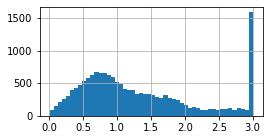



Histogram for: Number of shopping_gallery within 1 km


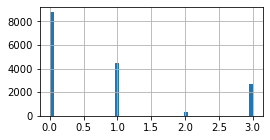



Histogram for: Distance to nearest shopping_centre


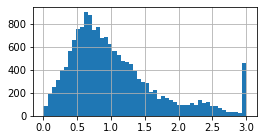



Histogram for: Number of shopping_centre within 1 km


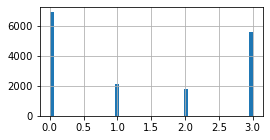



Histogram for: Distance to nearest large_establishment


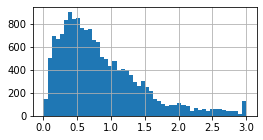



Histogram for: Number of large_establishment within 1 km


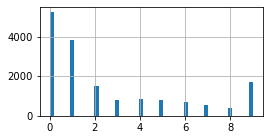



Histogram for: Distance to nearest market


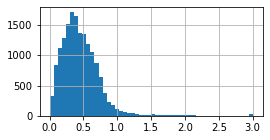



Histogram for: Number of market within 1 km


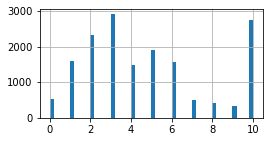



Histogram for: social_cohesion_score


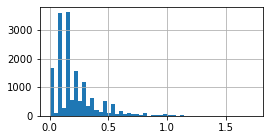



Histogram for: Life expectancy


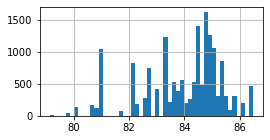



Histogram for: Density (hab/ha)


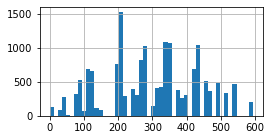



Histogram for: Density net (hab/ha)


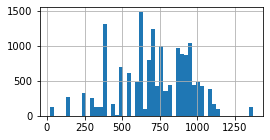



Histogram for: under 18 %


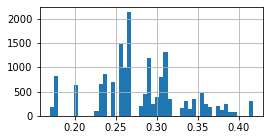



Histogram for: 64 plus %


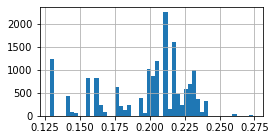



Histogram for: Natural population growth %


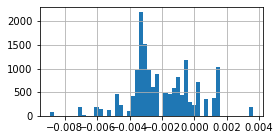



Histogram for: Net immigration rate %


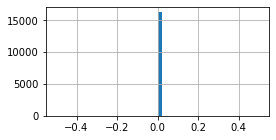



Histogram for:  Distance to nearest theatre


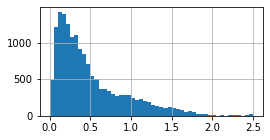

In [60]:
for col in social_features_select_df.columns:
    print(f'Histogram for: {col}')
    social_features_select_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**PCA SOCIAL FEATURES**

*police stations*

[[-0.18606399  0.98253763]]
[0.22784768]
Explained Variance by Component 0 is 0.9548406304238118%.
Coefficient for Distance to nearest police_stations is -0.04239424885611099
Coefficient for Number of police_stations within 1 km is 0.22386891569304584


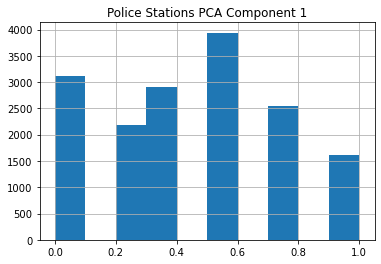

In [61]:
pca_police_stations_df = pca_creation(social_features_select_df,['Distance to nearest police_stations',
       'Number of police_stations within 1 km'], 1, 'Police Stations', False)
pca_police_stations_df.hist()
plt.show()

*cinema, theatre and concert*

[[-0.07880086  0.12594097 -0.07886275  0.96539522 -0.14131888  0.14053825]]
[0.09029902]
Explained Variance by Component 0 is 0.8944084473681964%.
Coefficient for Distance to nearest cinema is -0.007115640449061702
Coefficient for Number of cinema within 0.5 km is 0.011372346511395515
Coefficient for Distance to nearest theatre is -0.00712122927243901
Coefficient for Number of theatre within 0.5 km is 0.08717424623636767
Coefficient for Distance to nearest concert is -0.012760957292229626
Coefficient for Number of concert within 0.5 km is 0.012690466534032191


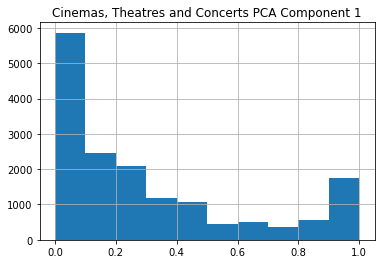

In [62]:
pca_cinema_theatre_concert_df = pca_creation(social_features_select_df,['Distance to nearest cinema',
       'Number of cinema within 0.5 km', 'Distance to nearest theatre',
       'Number of theatre within 0.5 km', 'Distance to nearest concert',
       'Number of concert within 0.5 km'],1, 'Cinemas, Theatres and Concerts', False)
pca_cinema_theatre_concert_df.hist()
plt.show()

*bar and restaurant*

[[-0.14433877  0.86709627 -0.03772928  0.47527558]]
[0.15136817]
Explained Variance by Component 0 is 0.7940349365166267%.
Coefficient for Distance to nearest bar is -0.02184829479903353
Coefficient for Number of bar within 0.25 km is 0.13125077560537238
Coefficient for Distance to nearest restaurant is -0.005711012398086966
Coefficient for Number of restaurant within 0.25 km is 0.07194159511054476


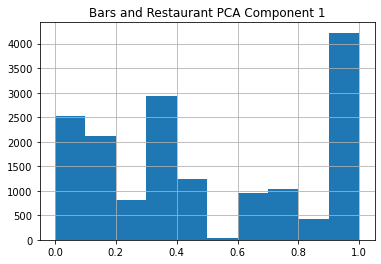

In [63]:
pca_bar_and_restaurant_df = pca_creation(social_features_select_df,['Distance to nearest bar',
       'Number of bar within 0.25 km', 'Distance to nearest restaurant',
       'Number of restaurant within 0.25 km'],1, 'Bars and Restaurant', False)
pca_bar_and_restaurant_df.hist()
plt.show()

*education*

[[-0.02496312  0.76978929 -0.01788784  0.63755887]]
[0.07086966]
Explained Variance by Component 0 is 0.7729996414922352%.
Coefficient for Distance to nearest under_three_education is -0.0017691280544158876
Coefficient for Number of under_three_education within 0.5 km is 0.05455470580867844
Coefficient for Distance to nearest three_to_six_education is -0.0012677053093716028
Coefficient for Number of three_to_six_education within 0.5 km is 0.045183581216577645


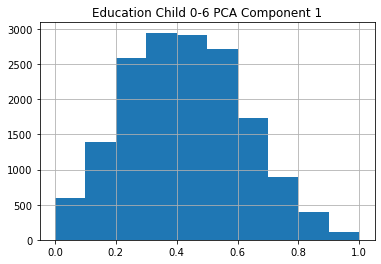

In [64]:
pca_education_df = pca_creation(social_features_select_df,['Distance to nearest under_three_education',
       'Number of under_three_education within 0.5 km',
       'Distance to nearest three_to_six_education',
       'Number of three_to_six_education within 0.5 km'],1, 'Education Child 0-6', False)
pca_education_df.hist()
plt.show()

[[-0.01986948  0.75599158 -0.02938764  0.65361939]]
[0.07071396]
Explained Variance by Component 0 is 0.8483487557036745%.
Coefficient for Distance to nearest primary_school is -0.0014050498199865646
Coefficient for Number of primary_school within 0.5 km is 0.053459158209690646
Coefficient for Distance to nearest secundary_school is -0.0020781164320801547
Coefficient for Number of secundary_school within 0.5 km is 0.04622001523145898


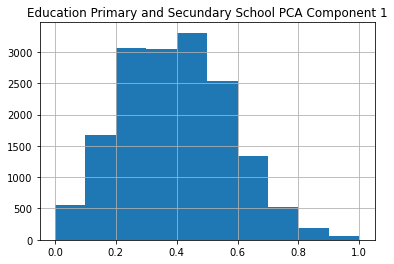

In [65]:
pca_education_df = pca_education_df.merge(pca_creation(social_features_select_df,['Distance to nearest primary_school',
       'Number of primary_school within 0.5 km',
       'Distance to nearest secundary_school',
       'Number of secundary_school within 0.5 km',
       #'Distance to nearest university', 'Number of university within 0.5 km'
                                                          ],1, 'Education Primary and Secundary School', False), 
                    left_index=True, right_index=True)
pca_education_df.iloc[:,-1:].hist()
plt.show()

[[-0.01888888  0.54640193 -0.0162954   0.59963965 -0.01625998  0.58394392]]
[0.05966488]
Explained Variance by Component 0 is 0.7754363746859264%.
Coefficient for Distance to nearest under_three_education is -0.001127002709453866
Coefficient for Number of under_three_education within 0.5 km is 0.03260100554296221
Coefficient for Distance to nearest three_to_six_education is -0.0009722628703503538
Coefficient for Number of three_to_six_education within 0.5 km is 0.03577742796020077
Coefficient for Distance to nearest primary_school is -0.0009701495553036287
Coefficient for Number of primary_school within 0.5 km is 0.034840944192492715


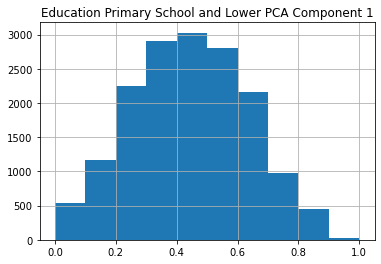

In [66]:
pca_education_df = pca_education_df.merge(pca_creation(social_features_select_df,['Distance to nearest under_three_education',
       'Number of under_three_education within 0.5 km',
       'Distance to nearest three_to_six_education',
       'Number of three_to_six_education within 0.5 km','Distance to nearest primary_school',
       'Number of primary_school within 0.5 km',
     #  'Distance to nearest secundary_school',
    #   'Number of secundary_school within 0.5 km',
       #'Distance to nearest university', 'Number of university within 0.5 km'
                                                          ],1, 'Education Primary School and Lower', False), 
                    left_index=True, right_index=True)
pca_education_df.iloc[:,-1:].hist()
plt.show()

[[-0.01689349  0.47690035 -0.01487627  0.55651585 -0.01502114  0.54734073
  -0.02002943  0.40266709]]
[0.05686542]
Explained Variance by Component 0 is 0.7224566589520663%.
Coefficient for Distance to nearest under_three_education is -0.0009606552150728001
Coefficient for Number of under_three_education within 0.5 km is 0.027119137438041535
Coefficient for Distance to nearest three_to_six_education is -0.0008459451933157859
Coefficient for Number of three_to_six_education within 0.5 km is 0.03164650620509026
Coefficient for Distance to nearest primary_school is -0.0008541834016170816
Coefficient for Number of primary_school within 0.5 km is 0.031124759336172918
Coefficient for Distance to nearest secundary_school is -0.0011389816509466944
Coefficient for Number of secundary_school within 0.5 km is 0.022897832066073223


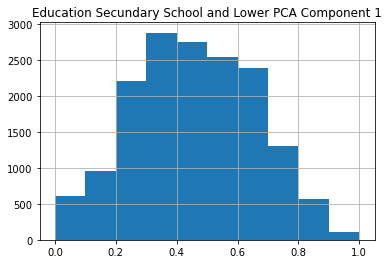

In [67]:
pca_education_df = pca_education_df.merge(pca_creation(social_features_select_df,['Distance to nearest under_three_education',
       'Number of under_three_education within 0.5 km',
       'Distance to nearest three_to_six_education',
       'Number of three_to_six_education within 0.5 km','Distance to nearest primary_school',
       'Number of primary_school within 0.5 km',
       'Distance to nearest secundary_school',
       'Number of secundary_school within 0.5 km',
       #'Distance to nearest university', 'Number of university within 0.5 km'
                                                          ],1, 'Education Secundary School and Lower', False), 
                    left_index=True, right_index=True)
pca_education_df.iloc[:,-1:].hist()
plt.show()

[[-0.04304272  0.99907323]]
[0.09969916]
Explained Variance by Component 0 is 0.9959371676201171%.
Coefficient for Distance to nearest secundary_school is -0.004291322842892391
Coefficient for Number of secundary_school within 0.5 km is 0.09960676303135732


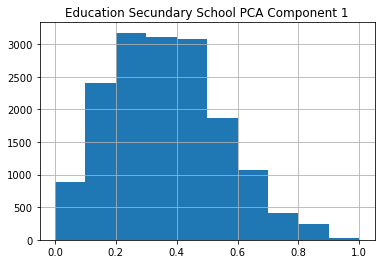

In [68]:
pca_education_df = pca_education_df.merge(pca_creation(social_features_select_df,[
      'Distance to nearest secundary_school',
      'Number of secundary_school within 0.5 km'
       #,'Distance to nearest university', 'Number of university within 0.5 km'
                                                          ],1, 'Education Secundary School', False), 
                    left_index=True, right_index=True)
pca_education_df.iloc[:,-1:].hist()
plt.show()

[[-0.15069439  0.9885804 ]]
[0.18799484]
Explained Variance by Component 0 is 0.9754979650483019%.
Coefficient for Distance to nearest university is -0.028329768035203665
Coefficient for Number of university within 0.5 km is 0.18584801608832494


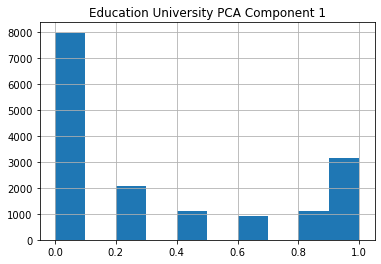

In [69]:
pca_education_df = pca_education_df.merge(pca_creation(social_features_select_df,['Distance to nearest university', 'Number of university within 0.5 km'
                                                          ],1, 'Education University', False),
                    left_index=True, right_index=True)
pca_education_df.iloc[:,-1:].hist()
plt.show()

[[-0.00607464  0.26234817 -0.15050605  0.95314451]
 [-0.0432909   0.9636905   0.01597367 -0.26300449]]
[0.13806064 0.09096855]
Explained Variance by Component 0 is 0.5472640092228711%.
Coefficient for Distance to nearest secundary_school is -0.0008386686728333827
Coefficient for Number of secundary_school within 0.5 km is 0.03621995650782261
Coefficient for Distance to nearest university is -0.020778961555575994
Coefficient for Number of university within 0.5 km is 0.1315917425683025
Explained Variance by Component 1 is 0.4376367392568276%.
Coefficient for Distance to nearest secundary_school is -0.0039381105664263935
Coefficient for Number of secundary_school within 0.5 km is 0.08766553037916909
Coefficient for Distance to nearest university is 0.0014531013760275778
Coefficient for Number of university within 0.5 km is -0.02392513746269409


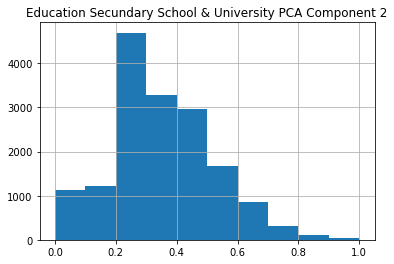

In [70]:
pca_education_df = pca_education_df.merge(pca_creation(social_features_select_df,[
      'Distance to nearest secundary_school',
      'Number of secundary_school within 0.5 km'
       ,'Distance to nearest university', 'Number of university within 0.5 km'
                                                          ],2, 'Education Secundary School & University', False), 
                    left_index=True, right_index=True)
pca_education_df.iloc[:,-1:].hist()
plt.show()

In [71]:
pca_education_df.corr()

,Education Child 0-6 PCA Component 1,Education Primary and Secundary School PCA Component 1,Education Primary School and Lower PCA Component 1,Education Secundary School and Lower PCA Component 1,Education Secundary School PCA Component 1,Education University PCA Component 1,Education Secundary School & University PCA Component 1,Education Secundary School & University PCA Component 2
Education Child 0-6 PCA Component 1,1.000000,0.763581,0.964720,0.935497,0.571898,-0.035348,1.015289e-01,5.673369e-01
Education Primary and Secundary School PCA Component 1,0.763581,1.000000,0.879949,0.940537,0.900278,0.038542,2.499976e-01,8.649354e-01
Education Primary School and Lower PCA Component 1,0.964720,0.879949,1.000000,0.986516,0.655291,-0.013527,1.421481e-01,6.419463e-01
Education Secundary School and Lower PCA Component 1,0.935497,0.940537,0.986516,1.000000,0.769699,0.001512,1.836336e-01,7.488609e-01
Education Secundary School PCA Component 1,0.571898,0.900278,0.655291,0.769699,1.000000,0.056666,2.909782e-01,9.567204e-01
Education University PCA Component 1,-0.035348,0.038542,-0.013527,0.001512,0.056666,1.000000,9.716807e-01,-2.362974e-01
Education Secundary School & University PCA Component 1,0.101529,0.249998,0.142148,0.183634,0.290978,0.971681,1.000000e+00,-2.065711e-15
Education Secundary School & University PCA Component 2,0.567337,0.864935,0.641946,0.748861,0.956720,-0.236297,-2.065711e-15,1.000000e+00


*pharmacy*

[[-0.01954254  0.99980903]]
[0.09982459]
Explained Variance by Component 0 is 0.9988294535894982%.
Coefficient for Distance to nearest pharmacy is -0.001950825653676072
Coefficient for Number of pharmacy within 0.25 km is 0.09980552824509517


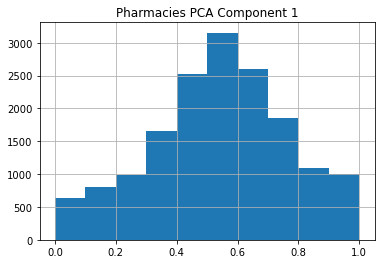

In [72]:
pca_pharamcy_df = pca_creation(social_features_select_df,['Distance to nearest pharmacy', 'Number of pharmacy within 0.25 km',
     ], 1, 'Pharmacies', False)
pca_pharamcy_df.hist()
plt.show()

*hospital and cliniques*

[[-0.08276777  0.99656886]]
[0.19582523]
Explained Variance by Component 0 is 0.9885000307984048%.
Coefficient for Distance to nearest hospital_and_cliniques is -0.016208018147519092
Coefficient for Number of hospital_and_cliniques within 0.5 km is 0.1951533299451245


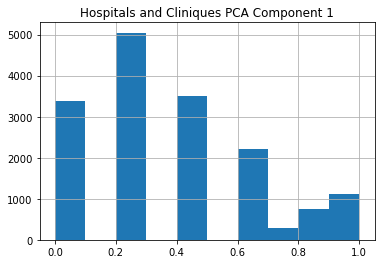

In [73]:
pca_hospital_df = pca_creation(social_features_select_df,[
       'Distance to nearest hospital_and_cliniques',
       'Number of hospital_and_cliniques within 0.5 km'], 1, 'Hospitals and Cliniques', False)
pca_hospital_df.hist()
plt.show()

*pharmacy & hospital and cliniques*

[[-0.01978459  0.99325642 -0.01704403  0.11295906]]
[0.09489091]
Explained Variance by Component 0 is 0.7224946797510335%.
Coefficient for Distance to nearest pharmacy is 0.0018773773318674202
Coefficient for Number of pharmacy within 0.25 km is -0.09425100259792714
Coefficient for Distance to nearest hospital_and_cliniques is 0.0016173235359015626
Coefficient for Number of hospital_and_cliniques within 0.5 km is -0.01071878789276461


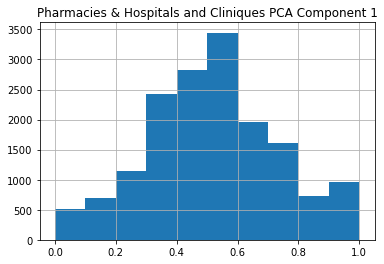

In [74]:
pca_pharamcy_and_hospital_df = pca_creation(social_features_select_df,['Distance to nearest pharmacy', 'Number of pharmacy within 0.25 km',
       'Distance to nearest hospital_and_cliniques',
       'Number of hospital_and_cliniques within 0.5 km'], 1, 'Pharmacies & Hospitals and Cliniques', True)
pca_pharamcy_and_hospital_df.hist()
plt.show()

*shopping places*

[[-0.1595916   0.12420685 -0.08635467  0.1480372  -0.13408741  0.95485685]]
[0.09537392]
Explained Variance by Component 0 is 0.7282100016071864%.
Coefficient for Distance to nearest shopping_gallery is -0.015220876546880983
Coefficient for Number of shopping_gallery within 1 km is 0.011846093775441645
Coefficient for Distance to nearest shopping_centre is -0.008235983347572154
Coefficient for Number of shopping_centre within 1 km is 0.014118887860863998
Coefficient for Distance to nearest large_establishment is -0.012788441690987811
Coefficient for Number of large_establishment within 1 km is 0.09106844121150726


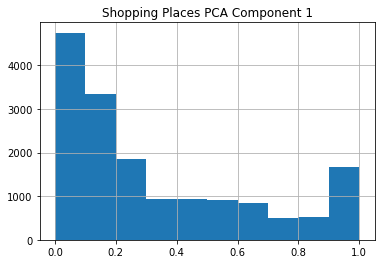

In [75]:
pca_shopping_places_df = pca_creation(social_features_select_df,['Distance to nearest shopping_gallery',
       'Number of shopping_gallery within 1 km',
       'Distance to nearest shopping_centre',
       'Number of shopping_centre within 1 km',
       'Distance to nearest large_establishment',
       'Number of large_establishment within 1 km',
       #'Distance to nearest market', 'Number of market within 1 km'
                                                                ], 1, 'Shopping Places', False)
pca_shopping_places_df.hist()
plt.show()

[[-0.03609557  0.99934834]]
[0.09899392]
Explained Variance by Component 0 is 0.9924521114193288%.
Coefficient for Distance to nearest market is -0.0035732419688092624
Coefficient for Number of market within 1 km is 0.09892940813279329


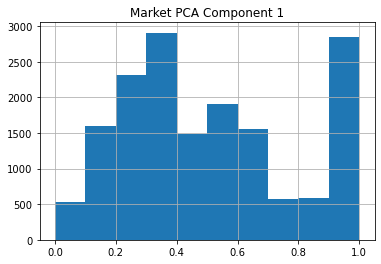

In [76]:
pca_shopping_places_df = pca_shopping_places_df.merge(pca_creation(social_features_select_df,[
       'Distance to nearest market', 'Number of market within 1 km'
                                                                ], 1, 'Market', False),
                             left_index=True, right_index=True)
pca_shopping_places_df.iloc[:,-1:].hist()
plt.show()

*merge PCA's*

In [77]:
social_features_select_df= social_features_select_df.merge(pca_police_stations_df, left_index=True, right_index=True)
social_features_select_df= social_features_select_df.merge(pca_cinema_theatre_concert_df, left_index=True, right_index=True)
social_features_select_df= social_features_select_df.merge(pca_bar_and_restaurant_df , left_index=True, right_index=True)
social_features_select_df= social_features_select_df.merge(pca_education_df , left_index=True, right_index=True)
social_features_select_df= social_features_select_df.merge(pca_pharamcy_and_hospital_df, left_index=True, right_index=True)
social_features_select_df= social_features_select_df.merge(pca_shopping_places_df , left_index=True, right_index=True)
social_features_select_df= social_features_select_df.merge(pca_pharamcy_df, left_index=True, right_index=True)
social_features_select_df= social_features_select_df.merge(pca_hospital_df, left_index=True, right_index=True)
social_features_select_df.head(2)

,Distance to nearest police_stations,Number of police_stations within 1 km,Distance to nearest cinema,Number of cinema within 0.5 km,Distance to nearest theatre,Number of theatre within 0.5 km,Distance to nearest concert,Number of concert within 0.5 km,Distance to nearest bar,Number of bar within 0.25 km,...,Education Secundary School and Lower PCA Component 1,Education Secundary School PCA Component 1,Education University PCA Component 1,Education Secundary School & University PCA Component 1,Education Secundary School & University PCA Component 2,Pharmacies & Hospitals and Cliniques PCA Component 1,Shopping Places PCA Component 1,Market PCA Component 1,Pharmacies PCA Component 1,Hospitals and Cliniques PCA Component 1
id,,,,,,,,,,,,,,,,,,,,,
31702050,0.507050,2,0.187379,2,0.194059,6,0.518905,0,0.083394,5,...,0.644039,0.701446,0.810905,0.830185,0.640539,0.337144,0.996931,0.305738,0.700435,0.013734
33148486,0.792018,2,0.556233,0,0.459548,2,0.687359,0,0.109383,5,...,0.536034,0.601517,0.997842,0.926293,0.528597,0.304053,0.946288,0.304833,0.700467,0.608242


In [78]:
social_features_select_df.corr()

,Distance to nearest police_stations,Number of police_stations within 1 km,Distance to nearest cinema,Number of cinema within 0.5 km,Distance to nearest theatre,Number of theatre within 0.5 km,Distance to nearest concert,Number of concert within 0.5 km,Distance to nearest bar,Number of bar within 0.25 km,...,Education Secundary School and Lower PCA Component 1,Education Secundary School PCA Component 1,Education University PCA Component 1,Education Secundary School & University PCA Component 1,Education Secundary School & University PCA Component 2,Pharmacies & Hospitals and Cliniques PCA Component 1,Shopping Places PCA Component 1,Market PCA Component 1,Pharmacies PCA Component 1,Hospitals and Cliniques PCA Component 1
Distance to nearest police_stations,1.000000,-0.625108,0.296570,-0.268251,0.299540,-0.330045,0.278666,-0.334877,0.344310,-0.272278,...,-0.205440,-0.205883,-0.204872,-2.451810e-01,-1.414410e-01,0.222065,-0.247028,-0.401295,-0.217970,-0.089194
Number of police_stations within 1 km,-0.625108,1.000000,-0.397080,0.308648,-0.277857,0.518811,-0.302332,0.533864,-0.289569,0.402069,...,0.076079,0.116660,0.334802,3.485256e-01,1.639626e-02,-0.253058,0.101433,0.613265,0.265551,-0.137492
Distance to nearest cinema,0.296570,-0.397080,1.000000,-0.656682,0.507204,-0.512880,0.409788,-0.374127,0.477807,-0.507629,...,-0.077739,-0.182720,-0.430945,-4.563797e-01,-5.316367e-02,0.349486,-0.465535,-0.456987,-0.348780,-0.062214
Number of cinema within 0.5 km,-0.268251,0.308648,-0.656682,1.000000,-0.406919,0.567731,-0.389207,0.452941,-0.336869,0.503279,...,0.034525,0.141657,0.378767,3.965785e-01,2.797746e-02,-0.327975,0.367873,0.405793,0.335567,-0.056736
Distance to nearest theatre,0.299540,-0.277857,0.507204,-0.406919,1.000000,-0.607184,0.525884,-0.327260,0.706313,-0.488257,...,-0.320243,-0.220272,-0.297345,-3.372286e-01,-1.288114e-01,0.499684,-0.376890,-0.490677,-0.495255,-0.135960
Number of theatre within 0.5 km,-0.330045,0.518811,-0.512880,0.567731,-0.607184,1.000000,-0.550336,0.659634,-0.486520,0.575697,...,0.174352,0.225114,0.271752,3.137974e-01,1.405487e-01,-0.433172,0.195943,0.638140,0.445950,-0.113782
Distance to nearest concert,0.278666,-0.302332,0.409788,-0.389207,0.525884,-0.550336,1.000000,-0.565490,0.628592,-0.514767,...,-0.072017,0.020619,-0.362205,-3.424384e-01,1.243683e-01,0.366131,-0.393683,-0.404540,-0.371500,0.020086
Number of concert within 0.5 km,-0.334877,0.533864,-0.374127,0.452941,-0.327260,0.659634,-0.565490,1.000000,-0.348660,0.504628,...,-0.025867,-0.015737,0.421323,4.000985e-01,-1.377894e-01,-0.297625,0.104375,0.582118,0.314776,-0.195460
Distance to nearest bar,0.344310,-0.289569,0.477807,-0.336869,0.706313,-0.486520,0.628592,-0.348660,1.000000,-0.610876,...,-0.278245,-0.188025,-0.447849,-4.740031e-01,-5.435508e-02,0.478800,-0.495849,-0.410929,-0.472617,-0.158257
Number of bar within 0.25 km,-0.272278,0.402069,-0.507629,0.503279,-0.488257,0.575697,-0.514767,0.504628,-0.610876,1.000000,...,0.102154,0.135965,0.525867,5.362485e-01,-2.022177e-02,-0.445910,0.462242,0.481700,0.448753,0.026819


**EXPORT FEATURES SOCIAL**

In [79]:
if export_sustainable_variables: 
    social_features_select_df.to_excel(sustainable_path+'social_dimension.xlsx')

## CULTURAL

In [80]:
df_cultural = data[['subdistrict']].copy(deep=True)
df_cultural.head(3)
cultural_features_distance = ['library','museum','religion','poi_culture']
cultural_features_gpkg = []
cultural_features_stats = []
cultural_ratio_within_dic = {}
cultural_ratio_within_dic['library'] = [2.5,1,0.5,0.25]
cultural_ratio_within_dic['museum']  = [2.5,1,0.5,0.25]
cultural_ratio_within_dic['religion'] = [2.5,1,0.5,0.25]
cultural_ratio_within_dic['poi_culture'] = [2.5,1,0.5,0.25]

**DISTANCE FEATURES**

In [81]:
cultural_feature_distance_df = create_distance_var_df(data, cultural_features_distance,cultural_ratio_within_dic, distance_path)
cultural_feature_distance_df.head(2)

library
feature is library and length df is: 16301
museum
feature is museum and length df is: 16301
religion
feature is religion and length df is: 16301
poi_culture
feature is poi_culture and length df is: 16301


,Distance to nearest library,Number of library within 2.5 km,Number of library within 1 km,Number of library within 0.5 km,Number of library within 0.25 km,Distance to nearest museum,Number of museum within 2.5 km,Number of museum within 1 km,Number of museum within 0.5 km,Number of museum within 0.25 km,Distance to nearest religion,Number of religion within 2.5 km,Number of religion within 1 km,Number of religion within 0.5 km,Number of religion within 0.25 km,Distance to nearest poi_culture,Number of poi_culture within 2.5 km,Number of poi_culture within 1 km,Number of poi_culture within 0.5 km,Number of poi_culture within 0.25 km
id,,,,,,,,,,,,,,,,,,,,
31702050,0.149608,140,46,11,5,0.203516,56,13,6,1,0.301932,165.0,35.0,5.0,0.0,0.120697,376,84,32,6
33148486,0.244781,134,34,10,1,0.055324,55,9,6,1,0.079465,173.0,33.0,8.0,3.0,0.025721,381,96,30,5


**GKPG CULTURAL** 

In [82]:
#empty

**STATS CULTURAL**

In [83]:
#empty

**MERGING DATASETS**

In [84]:
cultural_features_df = df_cultural.merge(cultural_feature_distance_df, left_index=True, right_index=True)
cultural_features_df.head(2)

,subdistrict,Distance to nearest library,Number of library within 2.5 km,Number of library within 1 km,Number of library within 0.5 km,Number of library within 0.25 km,Distance to nearest museum,Number of museum within 2.5 km,Number of museum within 1 km,Number of museum within 0.5 km,...,Distance to nearest religion,Number of religion within 2.5 km,Number of religion within 1 km,Number of religion within 0.5 km,Number of religion within 0.25 km,Distance to nearest poi_culture,Number of poi_culture within 2.5 km,Number of poi_culture within 1 km,Number of poi_culture within 0.5 km,Number of poi_culture within 0.25 km
id,,,,,,,,,,,,,,,,,,,,,
31702050,Subdistrict La Dreta de l'Eixample,0.149608,140,46,11,5,0.203516,56,13,6,...,0.301932,165.0,35.0,5.0,0.0,0.120697,376,84,32,6
33148486,Subdistrict La Dreta de l'Eixample,0.244781,134,34,10,1,0.055324,55,9,6,...,0.079465,173.0,33.0,8.0,3.0,0.025721,381,96,30,5


**MISSING DATA CULTURAL FEATURES**

In [85]:
"No Missing Values"
print(cultural_features_df.isnull().sum(axis = 0))

subdistrict                             0
Distance to nearest library             0
Number of library within 2.5 km         0
Number of library within 1 km           0
Number of library within 0.5 km         0
Number of library within 0.25 km        0
Distance to nearest museum              0
Number of museum within 2.5 km          0
Number of museum within 1 km            0
Number of museum within 0.5 km          0
Number of museum within 0.25 km         0
Distance to nearest religion            0
Number of religion within 2.5 km        0
Number of religion within 1 km          0
Number of religion within 0.5 km        0
Number of religion within 0.25 km       0
Distance to nearest poi_culture         0
Number of poi_culture within 2.5 km     0
Number of poi_culture within 1 km       0
Number of poi_culture within 0.5 km     0
Number of poi_culture within 0.25 km    0
dtype: int64


**HISTOGRAMS BEFORE TREATMENT AND SELECTION**

Histogram for: Distance to nearest library


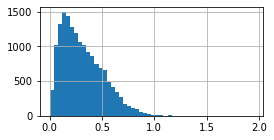



Histogram for: Number of library within 2.5 km


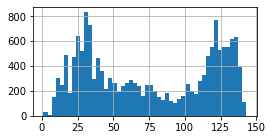



Histogram for: Number of library within 1 km


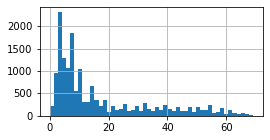



Histogram for: Number of library within 0.5 km


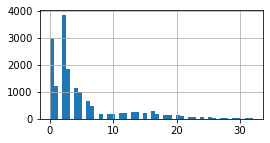



Histogram for: Number of library within 0.25 km


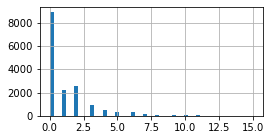



Histogram for: Distance to nearest museum


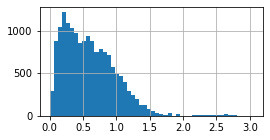



Histogram for: Number of museum within 2.5 km


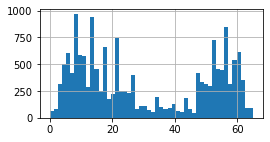



Histogram for: Number of museum within 1 km


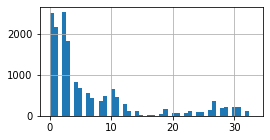



Histogram for: Number of museum within 0.5 km


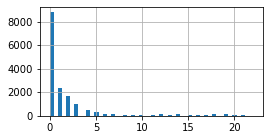



Histogram for: Number of museum within 0.25 km


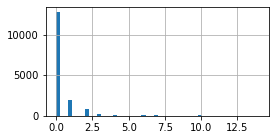



Histogram for: Distance to nearest religion


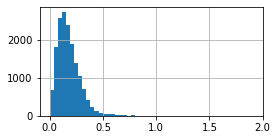



Histogram for: Number of religion within 2.5 km


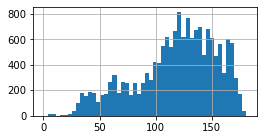



Histogram for: Number of religion within 1 km


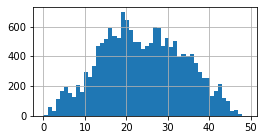



Histogram for: Number of religion within 0.5 km


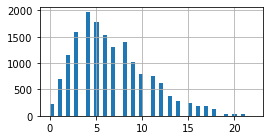



Histogram for: Number of religion within 0.25 km


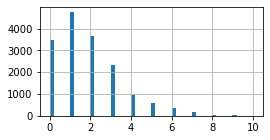



Histogram for: Distance to nearest poi_culture


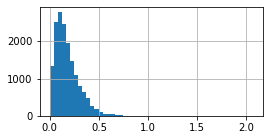



Histogram for: Number of poi_culture within 2.5 km


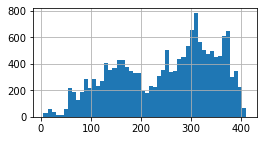



Histogram for: Number of poi_culture within 1 km


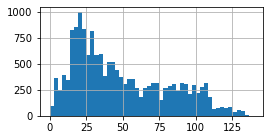



Histogram for: Number of poi_culture within 0.5 km


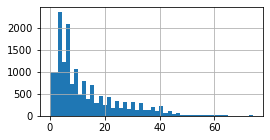



Histogram for: Number of poi_culture within 0.25 km


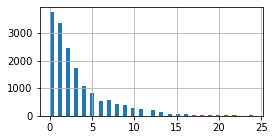

In [86]:
for col in cultural_features_df.iloc[:,1:].columns:
    print(f'Histogram for: {col}')
    cultural_features_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**SELECT FEATURES AND TRANCUATION**

In [87]:
cultural_features_select = ['Distance to nearest library','Number of library within 0.5 km','Distance to nearest museum','Number of museum within 0.5 km', 'Distance to nearest religion','Number of religion within 0.5 km','Distance to nearest poi_culture','Number of poi_culture within 0.5 km']
cultural_features_select_df = cultural_features_df[cultural_features_select]
cultural_features_select_df.head(2)

,Distance to nearest library,Number of library within 0.5 km,Distance to nearest museum,Number of museum within 0.5 km,Distance to nearest religion,Number of religion within 0.5 km,Distance to nearest poi_culture,Number of poi_culture within 0.5 km
id,,,,,,,,
31702050,0.149608,11,0.203516,6,0.301932,5.0,0.120697,32
33148486,0.244781,10,0.055324,6,0.079465,8.0,0.025721,30


In [88]:
cultural_features_select_df['Distance to nearest library'] = cultural_features_select_df['Distance to nearest library'].clip(0, 1.5)
cultural_features_select_df['Number of library within 0.5 km'] = cultural_features_select_df['Number of library within 0.5 km'].clip(0, 10)
cultural_features_select_df['Distance to nearest museum'] = cultural_features_select_df['Distance to nearest museum'].clip(0, 1.5)
cultural_features_select_df['Number of museum within 0.5 km'] = cultural_features_select_df['Number of museum within 0.5 km'].clip(0, 10)
cultural_features_select_df['Distance to nearest religion'] = cultural_features_select_df['Distance to nearest religion'].clip(0, 1.5)
cultural_features_select_df['Number of religion within 0.5 km'] = cultural_features_select_df['Number of religion within 0.5 km'].clip(0, 15)
cultural_features_select_df['Distance to nearest poi_culture'] = cultural_features_select_df['Distance to nearest poi_culture'].clip(0, 1)
cultural_features_select_df['Number of poi_culture within 0.5 km'] = cultural_features_select_df['Number of poi_culture within 0.5 km'].clip(0, 50)

In [89]:
cultural_features_select_df.corr()

,Distance to nearest library,Number of library within 0.5 km,Distance to nearest museum,Number of museum within 0.5 km,Distance to nearest religion,Number of religion within 0.5 km,Distance to nearest poi_culture,Number of poi_culture within 0.5 km
Distance to nearest library,1.000000,-0.692262,0.403054,-0.434028,0.309059,-0.396100,0.303687,-0.411367
Number of library within 0.5 km,-0.692262,1.000000,-0.560935,0.731080,-0.258876,0.554980,-0.346711,0.625051
Distance to nearest museum,0.403054,-0.560935,1.000000,-0.611462,0.180307,-0.351279,0.372861,-0.556509
Number of museum within 0.5 km,-0.434028,0.731080,-0.611462,1.000000,-0.216267,0.546779,-0.337768,0.675161
Distance to nearest religion,0.309059,-0.258876,0.180307,-0.216267,1.000000,-0.478809,0.163517,-0.248998
Number of religion within 0.5 km,-0.396100,0.554980,-0.351279,0.546779,-0.478809,1.000000,-0.271790,0.578112
Distance to nearest poi_culture,0.303687,-0.346711,0.372861,-0.337768,0.163517,-0.271790,1.000000,-0.545748
Number of poi_culture within 0.5 km,-0.411367,0.625051,-0.556509,0.675161,-0.248998,0.578112,-0.545748,1.000000


Histogram for: Distance to nearest library


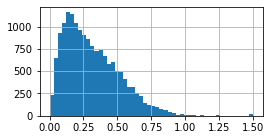



Histogram for: Number of library within 0.5 km


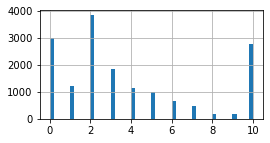



Histogram for: Distance to nearest museum


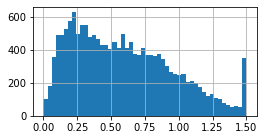



Histogram for: Number of museum within 0.5 km


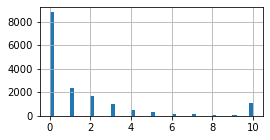



Histogram for: Distance to nearest religion


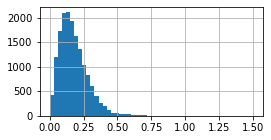



Histogram for: Number of religion within 0.5 km


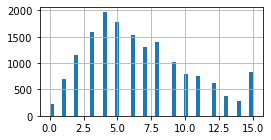



Histogram for: Distance to nearest poi_culture


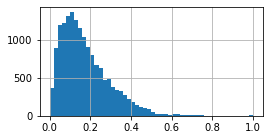



Histogram for: Number of poi_culture within 0.5 km


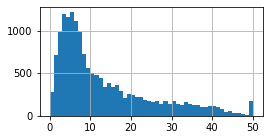

In [90]:
for col in cultural_features_select_df.iloc[:,:].columns:
    print(f'Histogram for: {col}')
    cultural_features_select_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**PCA FEATURES**

In [91]:
cultural_features_select_df.columns

Index(['Distance to nearest library', 'Number of library within 0.5 km',
       'Distance to nearest museum', 'Number of museum within 0.5 km',
       'Distance to nearest religion', 'Number of religion within 0.5 km',
       'Distance to nearest poi_culture',
       'Number of poi_culture within 0.5 km'],
      dtype='object')

*Museums and Libraries*

[[-0.03167512  0.80260237 -0.05567914  0.59306488]]
[0.07098506]
Explained Variance by Component 0 is 0.8687405874084505%.
Coefficient for Distance to nearest library is -0.002248460097149929
Coefficient for Number of library within 0.5 km is 0.05697277839352134
Coefficient for Distance to nearest museum is -0.003952387145287759
Coefficient for Number of museum within 0.5 km is 0.04209874641304015


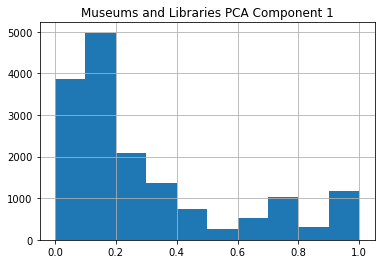

In [92]:
pca_museums_and_libraries_df = pca_creation(cultural_features_select_df, ['Distance to nearest library', 'Number of library within 0.5 km','Distance to nearest museum', 'Number of museum within 0.5 km'], 1, 'Museums and Libraries', False)
pca_museums_and_libraries_df.hist()
plt.show()

*Religious Institutions*

[[-0.01384827  0.99990411]]
[0.06658106]
Explained Variance by Component 0 is 0.9993566415649826%.
Coefficient for Distance to nearest religion is -0.000922032412199697
Coefficient for Number of religion within 0.5 km is 0.06657467580634831


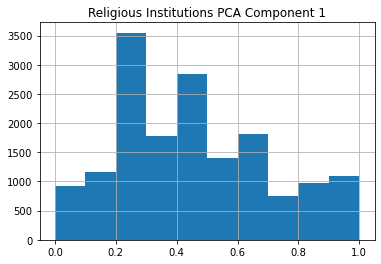

In [93]:
pca_religious_institutions_df = pca_creation(cultural_features_select_df, ['Distance to nearest religion', 'Number of religion within 0.5 km'], 1, 'Religious Institutions', False)
pca_religious_institutions_df.hist()
plt.show()

*Point of Interest Culture*

[[-0.0057428   0.99998351]]
[0.01999804]
Explained Variance by Component 0 is 0.9999222707922482%.
Coefficient for Distance to nearest poi_culture is -0.00011484476671801271
Coefficient for Number of poi_culture within 0.5 km is 0.019997710053517685


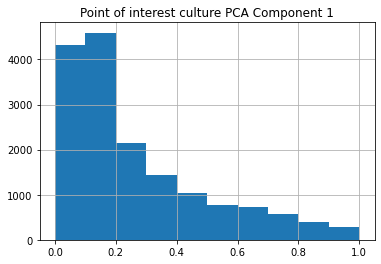

In [94]:
pca_POI_culture_df = pca_creation(cultural_features_select_df, ['Distance to nearest poi_culture', 'Number of poi_culture within 0.5 km'], 1, 'Point of interest culture', False)
pca_POI_culture_df.hist()
plt.show()

*Museum, Library and POI Culture*

[[-0.00745991  0.19049305 -0.01759391  0.16209881 -0.00555114  0.96800845]]
[0.01960855]
Explained Variance by Component 0 is 0.9301188585660219%.
Coefficient for Distance to nearest library is -0.00014627807096802937
Coefficient for Number of library within 0.5 km is 0.0037352923535461224
Coefficient for Distance to nearest museum is -0.0003449910748007564
Coefficient for Number of museum within 0.5 km is 0.003178522532198765
Coefficient for Distance to nearest poi_culture is -0.00010884989189347994
Coefficient for Number of poi_culture within 0.5 km is 0.018981241509520564


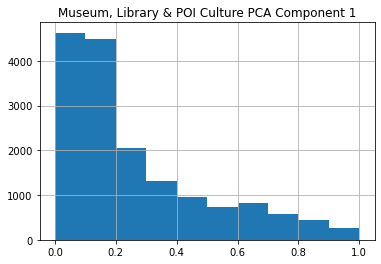

In [95]:
pca_museum_library_POI_culture_df = pca_creation(cultural_features_select_df, ['Distance to nearest library', 'Number of library within 0.5 km','Distance to nearest museum', 'Number of museum within 0.5 km','Distance to nearest poi_culture', 'Number of poi_culture within 0.5 km'], 1, 'Museum, Library & POI Culture', False)
pca_museum_library_POI_culture_df.hist()
plt.show()

*MERGE PCA*

In [96]:
cultural_features_select_df= cultural_features_select_df.merge(pca_museums_and_libraries_df, left_index=True, right_index=True)
cultural_features_select_df= cultural_features_select_df.merge(pca_religious_institutions_df, left_index=True, right_index=True)
cultural_features_select_df = cultural_features_select_df.merge(pca_POI_culture_df, left_index=True, right_index=True)
cultural_features_select_df = cultural_features_select_df.merge(pca_museum_library_POI_culture_df, left_index=True, right_index=True)

**EXPORT**

In [97]:
if export_sustainable_variables: 
    cultural_features_select_df.to_excel(sustainable_path+'cultural_dimension.xlsx')

## ECONOMIC/FINANCIAL

In [98]:
economic_financial_df = data[['subdistrict']].copy(deep=True)
economic_financial_df.head(3)
economic_financial_features_distance = []
economic_financial_features_gpkg = []
economic_financial_features_stats = []

**DISTANCE**

In [99]:
#nothing

**GPKG**

In [100]:
#nothing

**STATS**

In [101]:
url_base = 'https://github.com/NielsUPF/Thesis-MIIS-The-Price-Impact-of-Sustainability-on-Housing-Prices-in-Barcelona/blob/ec0b4379cb1cc274d71210aef7209d27750de492/Data/Sus_Var_Creation/subdistrict_stats/'

url_gini = url_base + "gini_index.xlsx?raw=true"
response = requests.get(url_gini)
file_content = response.content
gini_index_df = pd.read_excel(file_content)


url_p80_p20 = url_base + "p80_p20_income_distribution.xlsx?raw=true"
response = requests.get(url_p80_p20)
file_content = response.content
p80_p20_income_distribution_df = pd.read_excel(file_content)

url_bruto_household_income = url_base + "bruto_household_income.xlsx?raw=true"
response = requests.get(url_bruto_household_income)
file_content = response.content
bruto_household_income_df = pd.read_excel(file_content)

url_bruto_person_income = url_base + "bruto_person_income.xlsx?raw=true"
response = requests.get(url_bruto_person_income)
file_content = response.content
bruto_person_income_df = pd.read_excel(file_content)

url_disposable_income = url_base + "disposable_income.xlsx?raw=true"
response = requests.get(url_disposable_income)
file_content = response.content
disposable_income_df = pd.read_excel(file_content)

url_unemployment_weight = url_base + "unemployment_weight.xlsx?raw=true"
response = requests.get(url_unemployment_weight)
file_content = response.content
unemployment_weight_df = pd.read_excel(file_content)

#floats
#gini_index_df['Index_Gini'] = gini_index_df['Index_Gini'].astype(float)
#p80_p20_income_distribution_df['Distribucio_P80_20'] = p80_p20_income_distribution_df['Distribucio_P80_20'].astype(float)
#bruto_household_income_df['Import_Renda_Bruta_€'] = bruto_household_income_df['Import_Renda_Bruta_€'].astype(float)
#bruto_person_income_df['Import_Renda_Bruta_€'] = bruto_person_income_df['Import_Renda_Bruta_€'].astype(float)
#disposable_income_df['Euros_Any'] =disposable_income_df['Euros_Any'].astype(float)
#unemployment_weight_df['Pes_atur'] = unemployment_weight_df['Pes_atur'].astype(float)

#subdistrict_df = gini_index_df[['Codi_Barri','subdistrict']]
#subdistrict_df = subdistrict_df.drop_duplicates('Codi_Barri')
#take the mean of different count times
#gini_index_df = gini_index_df.groupby('Codi_Barri').mean()
#p80_p20_income_distribution_df = p80_p20_income_distribution_df.groupby('Codi_Barri').mean()
#bruto_household_income_df = bruto_household_income_df.groupby('Codi_Barri').mean()
#bruto_person_income_df =  bruto_person_income_df.groupby('Codi_Barri').mean()
#disposable_income_df =  disposable_income_df.groupby('Codi_Barri').mean()
#unemployment_weight_df = unemployment_weight_df.groupby('Codi_Barri').mean()

economic_features_stats_df = gini_index_df.merge(p80_p20_income_distribution_df['Distribucio_P80_20'], left_index=True,right_index=True)
economic_features_stats_df.rename(columns={'Index_Gini': 'Gini Index'}, inplace=True)
economic_features_stats_df = economic_features_stats_df.merge(bruto_household_income_df['Import_Renda_Bruta_€'], left_index=True,right_index=True)
economic_features_stats_df.rename(columns={'Distribucio_P80_20': 'Income Distribution P80/P20'}, inplace=True)
economic_features_stats_df.rename(columns={'Import_Renda_Bruta_€': 'AVG income household'}, inplace=True)
economic_features_stats_df = economic_features_stats_df.merge(bruto_person_income_df['Import_Renda_Bruta_€'], left_index=True,right_index=True)
economic_features_stats_df.rename(columns={'Import_Renda_Bruta_€': 'AVG income person'}, inplace=True)
economic_features_stats_df = economic_features_stats_df.merge(disposable_income_df['Euros_Any'], left_index=True, right_index=True)
economic_features_stats_df.rename(columns={'Euros_Any': 'AVG disposable income'}, inplace=True)
economic_features_stats_df = economic_features_stats_df.merge(unemployment_weight_df['Pes_atur'], left_index=True, right_index=True)
economic_features_stats_df.rename(columns={'Pes_atur': 'AVG unemployment rate %'}, inplace=True)

#economic_features_stats_df= economic_features_stats_df.merge(subdistrict_df,left_index=True, right_on='Codi_Barri')
economic_features_stats_df.head(2)
economic_features_stats_df.reset_index(inplace=True)
#economic_features_stats_df = economic_features_stats_df.groupby('subdistrict').mean()
economic_features_stats_df.reset_index(inplace=True)
economic_features_stats_df = economic_features_stats_df.set_index('index')

In [102]:
economic_features_stats_df

,level_0,Unnamed: 0,subdistrict,Codi_Barri,Gini Index,_id,WA_share,Income Distribution P80/P20,AVG income household,AVG income person,AVG disposable income,AVG unemployment rate %
index,,,,,,,,,,,,
0,0,0,Subdistrict Baró de Viver,58,28.700000,832.5,1,2.650000,27885.500000,10774.000000,12022.000000,5.900000
1,1,1,Subdistrict Can Baró,34,31.842857,609.0,1,2.700000,44821.714286,19069.285714,20248.000000,5.350000
2,2,2,Subdistrict Can Peguera - El Turó de la Peira,93,30.888713,1509.0,1,2.785197,31995.091286,12998.470459,14328.005216,6.692030
3,3,3,Subdistrict Canyelles,49,24.340000,771.0,1,2.140000,40956.800000,16981.600000,17878.000000,9.750000
4,4,4,Subdistrict Ciutat Meridiana - Torre Baró - Va...,165,30.972437,2464.0,1,2.886276,28454.310914,9750.993085,10962.965909,10.816728
...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,63,Subdistrict Vallcarca i els Penitents,28,34.390909,505.0,1,3.109091,61690.636364,25370.818182,26010.000000,5.250000
64,64,64,Subdistrict Vallvidrera - El Tibidabo i les Pl...,22,36.966667,403.0,1,3.133333,79816.333333,28056.000000,29429.000000,2.800000
65,65,65,Subdistrict Verdun,51,30.162500,787.5,1,2.650000,30171.500000,12653.750000,14267.000000,7.800000


In [103]:
len(economic_features_stats_df.subdistrict.unique())

68

In [104]:
economic_features_stats_df

,level_0,Unnamed: 0,subdistrict,Codi_Barri,Gini Index,_id,WA_share,Income Distribution P80/P20,AVG income household,AVG income person,AVG disposable income,AVG unemployment rate %
index,,,,,,,,,,,,
0,0,0,Subdistrict Baró de Viver,58,28.700000,832.5,1,2.650000,27885.500000,10774.000000,12022.000000,5.900000
1,1,1,Subdistrict Can Baró,34,31.842857,609.0,1,2.700000,44821.714286,19069.285714,20248.000000,5.350000
2,2,2,Subdistrict Can Peguera - El Turó de la Peira,93,30.888713,1509.0,1,2.785197,31995.091286,12998.470459,14328.005216,6.692030
3,3,3,Subdistrict Canyelles,49,24.340000,771.0,1,2.140000,40956.800000,16981.600000,17878.000000,9.750000
4,4,4,Subdistrict Ciutat Meridiana - Torre Baró - Va...,165,30.972437,2464.0,1,2.886276,28454.310914,9750.993085,10962.965909,10.816728
...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,63,Subdistrict Vallcarca i els Penitents,28,34.390909,505.0,1,3.109091,61690.636364,25370.818182,26010.000000,5.250000
64,64,64,Subdistrict Vallvidrera - El Tibidabo i les Pl...,22,36.966667,403.0,1,3.133333,79816.333333,28056.000000,29429.000000,2.800000
65,65,65,Subdistrict Verdun,51,30.162500,787.5,1,2.650000,30171.500000,12653.750000,14267.000000,7.800000


**MERGING**

In [105]:
economic_financial_df

,subdistrict
id,
31702050,Subdistrict La Dreta de l'Eixample
33148486,Subdistrict La Dreta de l'Eixample
39158016,Subdistrict La Dreta de l'Eixample
40351755,Subdistrict La Dreta de l'Eixample
93970881,Subdistrict La Dreta de l'Eixample
...,...
101135260,Subdistrict Sant Andreu
101135697,Subdistrict Baró de Viver
101135655,Subdistrict El Bon Pastor


In [106]:
economic_financial_df['id'] = economic_financial_df.index
economic_features_df = economic_financial_df.merge(economic_features_stats_df, left_on='subdistrict', right_on='subdistrict')
economic_features_df.set_index('id', inplace=True)
economic_features_df.head(2)

,subdistrict,level_0,Unnamed: 0,Codi_Barri,Gini Index,_id,WA_share,Income Distribution P80/P20,AVG income household,AVG income person,AVG disposable income,AVG unemployment rate %
id,,,,,,,,,,,,
31702050,Subdistrict La Dreta de l'Eixample,28,28,7,37.206897,123.0,1,3.368966,68383.758621,29086.827586,30341.0,3.85
33148486,Subdistrict La Dreta de l'Eixample,28,28,7,37.206897,123.0,1,3.368966,68383.758621,29086.827586,30341.0,3.85


**MISSING DATA ECONOMIC/FINANCIAL FEATURES**

In [107]:
"No Missing Values"
print(economic_features_df.isnull().sum(axis = 0))

subdistrict                    0
level_0                        0
Unnamed: 0                     0
Codi_Barri                     0
Gini Index                     0
_id                            0
WA_share                       0
Income Distribution P80/P20    0
AVG income household           0
AVG income person              0
AVG disposable income          0
AVG unemployment rate %        0
dtype: int64


**HISTOGRAMS BEFORE TREATMENT**

Histogram for: subdistrict


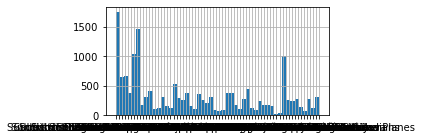



Histogram for: level_0


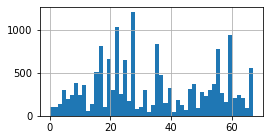



Histogram for: Unnamed: 0


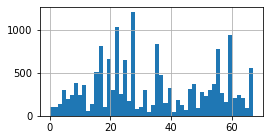



Histogram for: Codi_Barri


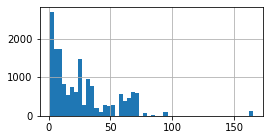



Histogram for: Gini Index


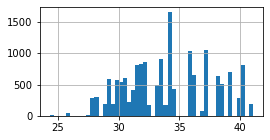



Histogram for: _id


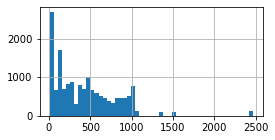



Histogram for: WA_share


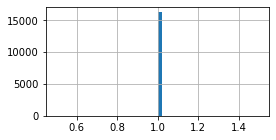



Histogram for: Income Distribution P80/P20


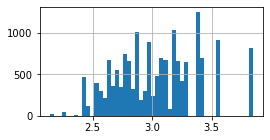



Histogram for: AVG income household


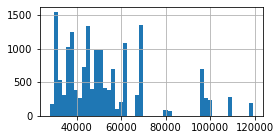



Histogram for: AVG income person


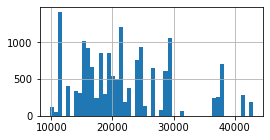



Histogram for: AVG disposable income


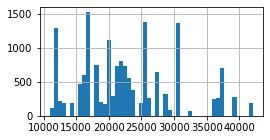



Histogram for: AVG unemployment rate %


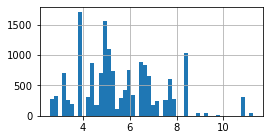

In [108]:
for col in economic_features_df.columns:
    print(f'Histogram for: {col}')
    economic_features_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**SELECT FEATURES**

In [109]:
economic_features_select = ['Income Distribution P80/P20','AVG income household','AVG unemployment rate %','Gini Index']
economic_features_select_df = economic_features_df[economic_features_select]

Histogram for: Income Distribution P80/P20


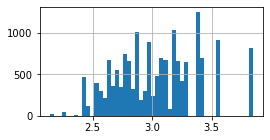



Histogram for: AVG income household


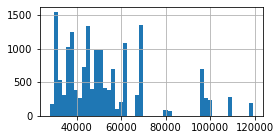



Histogram for: AVG unemployment rate %


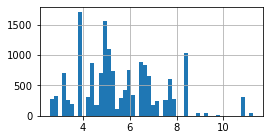



Histogram for: Gini Index


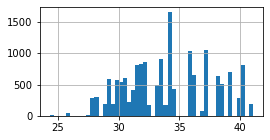

In [110]:
for col in economic_features_select_df.columns:
    print(f'Histogram for: {col}')
    economic_features_select_df[col].hist(bins=50, figsize=[4,2])
    plt.show()
    print("")
    print("")

**PCA FEATURES**

*P80/P20 Income Distribution & Gini-Index*

In [111]:
economic_features_select_df['AVG unemployment rate %'] = economic_features_select_df['AVG unemployment rate %']  / 100
economic_features_select_df['Gini Index'] = economic_features_select_df['Gini Index']/100
economic_features_select_df['Income Distribution P80/P20'] = economic_features_select_df['Income Distribution P80/P20'] / 10
economic_features_select_df['AVG income household'] = economic_features_select_df['AVG income household'] / 100000

[[-0.58618674 -0.59686776 -0.36292371 -0.4103905 ]]
[3.64944819]
Explained Variance by Component 0 is 0.9765339546367838%.
Coefficient for Income Distribution P80/P20 is -2.139258135187093
Coefficient for Gini Index is -2.1782379569762074
Coefficient for sq(Income Distribution P80/P20) is -1.3244712905165648
Coefficient for sq(Gini Index) is -1.4976988873224115


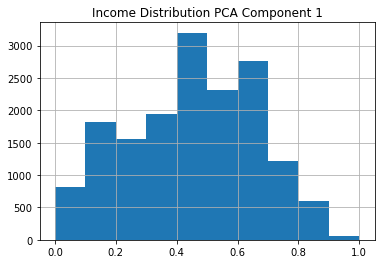

In [112]:
economic_features_select_df['sq(Income Distribution P80/P20)'] = economic_features_select_df['Income Distribution P80/P20']**2
economic_features_select_df['sq(Gini Index)'] = economic_features_select_df['Gini Index']**2
pca_p80_p20_gini_index_df = pca_creation(economic_features_select_df, ['Income Distribution P80/P20', 'Gini Index', 'sq(Income Distribution P80/P20)','sq(Gini Index)']
                                         , 1, 'Income Distribution', False)
pca_p80_p20_gini_index_df.hist()
plt.show()

In [113]:
economic_features_select_df.columns

Index(['Income Distribution P80/P20', 'AVG income household',
       'AVG unemployment rate %', 'Gini Index',
       'sq(Income Distribution P80/P20)', 'sq(Gini Index)'],
      dtype='object')

*Average Household Income & Unemployment Rate*

[[ 0.59230964 -0.03571394  0.80490905 -0.00390076]]
[0.61617798]
Explained Variance by Component 0 is 0.9905458488894148%.
Coefficient for AVG income household is 0.36496815805428784
Coefficient for AVG unemployment rate % is -0.022006143522169522
Coefficient for sq(AVG income household) is 0.49596723376465335
Coefficient for sq(AVG unemployment rate %) is -0.002403563321289774


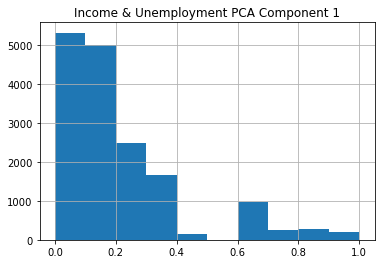

In [114]:
economic_features_select_df['sq(AVG income household)'] = economic_features_select_df['AVG income household']**2
economic_features_select_df['sq(AVG unemployment rate %)'] = economic_features_select_df['AVG unemployment rate %']**2
pca_AVG_income_AVG_unemployment_df = pca_creation(economic_features_select_df, ['AVG income household', 'AVG unemployment rate %','sq(AVG income household)','sq(AVG unemployment rate %)'], 1, 'Income & Unemployment', False)
pca_AVG_income_AVG_unemployment_df.hist()
plt.show()

In [115]:
economic_features_select_df.index.unique()

Int64Index([ 31702050,  33148486,  39158016,  40351755,  93970881,  84114683,
             84144318,  84809865,  85156127,  85475409,
            ...
            101134276, 101134305, 101135260, 101137418,  99826281, 100495793,
            100555971, 101078597, 101079614, 101135697],
           dtype='int64', name='id', length=16297)

In [116]:
pca_AVG_income_AVG_unemployment_df.merge(economic_features_select_df, right_index=True, left_index=True)

,Income & Unemployment PCA Component 1,Income Distribution P80/P20,AVG income household,AVG unemployment rate %,Gini Index,sq(Income Distribution P80/P20),sq(Gini Index),sq(AVG income household),sq(AVG unemployment rate %)
id,,,,,,,,,
31702050,0.341626,0.336897,0.683838,0.0385,0.372069,0.113499,0.138435,0.467634,0.001482
33148486,0.341626,0.336897,0.683838,0.0385,0.372069,0.113499,0.138435,0.467634,0.001482
39158016,0.341626,0.336897,0.683838,0.0385,0.372069,0.113499,0.138435,0.467634,0.001482
40351755,0.341626,0.336897,0.683838,0.0385,0.372069,0.113499,0.138435,0.467634,0.001482
93970881,0.341626,0.336897,0.683838,0.0385,0.372069,0.113499,0.138435,0.467634,0.001482
...,...,...,...,...,...,...,...,...,...
100495793,0.000000,0.265000,0.278855,0.0590,0.287000,0.070225,0.082369,0.077760,0.003481
100555971,0.000000,0.265000,0.278855,0.0590,0.287000,0.070225,0.082369,0.077760,0.003481
101078597,0.000000,0.265000,0.278855,0.0590,0.287000,0.070225,0.082369,0.077760,0.003481


*MERGE PCA*

In [117]:
economic_features_select_df= economic_features_select_df.merge(pca_p80_p20_gini_index_df, left_index=True, right_index=True)
economic_features_select_df= economic_features_select_df.merge(pca_AVG_income_AVG_unemployment_df, left_index=True, right_index=True)
economic_features_select_df.head(2)

,Income Distribution P80/P20,AVG income household,AVG unemployment rate %,Gini Index,sq(Income Distribution P80/P20),sq(Gini Index),sq(AVG income household),sq(AVG unemployment rate %),Income Distribution PCA Component 1,Income & Unemployment PCA Component 1
id,,,,,,,,,,
31702050,0.336897,0.683838,0.0385,0.372069,0.113499,0.138435,0.467634,0.001482,0.248544,0.341626
33148486,0.336897,0.683838,0.0385,0.372069,0.113499,0.138435,0.467634,0.001482,0.248544,0.341626


**EXPORT**

In [118]:
if export_sustainable_variables: 
    economic_features_select_df.to_excel(economic_path+'economic_financial_dimension.xlsx')